# Advanced Data Analysis 23/24: project


**In the solutions for exercises 1 to 4 you should include necessarily one solution using Pandas/scikit learn and one using Spark.**

Some useful links:
* [Pandas documentations](https://pandas.pydata.org/docs/)

* [scikit-learn](https://scikit-learn.org/stable/)

* [Spark web site](https://spark.apache.org/)

* [Spark MLlib main page](https://spark.apache.org/mllib/)
* [Spark MLlib guide](https://spark.apache.org/docs/latest/ml-guide.html)

* [Spark GraphX main page](https://spark.apache.org/graphx/)
* [Spark GraphFrames main page](https://graphframes.github.io/graphframes/docs/_site/index.html)
* [Spark GraphFrames User Guide](https://graphframes.github.io/graphframes/docs/_site/user-guide.html)

Run the following cell just to check if it is running in COLAB.

In [ ]:
import sys
import os

IN_COLAB = 'google.colab' in sys.modules
WITH_SPARK = IN_COLAB

## Install software

This cell installs the software needed to run the project.

In [ ]:
if( WITH_SPARK):
    !apt-get install openjdk-17-jdk-headless
    !apt-get wget
    !pip install pyspark==3.5.0
    !wget https://repos.spark-packages.org/graphframes/graphframes/0.8.3-spark3.5-s_2.13/graphframes-0.8.3-spark3.5-s_2.13.jar
    os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars graphframes-0.8.3-spark3.5-s_2.13.jar pyspark-shell'
    os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

!pip install gdown
!mkdir checkpoint

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  openjdk-17-jre-headless
Suggested packages:
  openjdk-17-demo openjdk-17-source libnss-mdns fonts-dejavu-extra fonts-ipafont-gothic
  fonts-ipafont-mincho fonts-wqy-microhei | fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-17-jdk-headless openjdk-17-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 15 not upgraded.
Need to get 119 MB of archives.
After this operation, 271 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 openjdk-17-jre-headless amd64 17.0.9+9-1~22.04 [48.2 MB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 openjdk-17-jdk-headless amd64 17.0.9+9-1~22.04 [71.1 MB]
Fetched 119 MB in 3s (35.0 MB/s)
Selecting previously unselected package openjdk-17-jre-headless:amd64.
(Reading database ... 120882 

## Setup

The following cell will import the used packages.

In [ ]:
from zipfile import ZipFile
import time
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
if( WITH_SPARK):
    import pyspark
    import pyspark.pandas as ps
    from pyspark.sql import SparkSession
    from pyspark.sql.types import *
    from pyspark.sql.functions import *
    from pyspark.sql import functions as F
    from pyspark.ml.linalg import Vectors
    from pyspark.ml.clustering import KMeans
    from pyspark.ml.evaluation import *
    from pyspark.ml.feature import *
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns

## Dataset

In this project, you will be asked to perform analysis of [Bitcoin](https://en.wikipedia.org/wiki/Bitcoin) transactions, a cryptocurrency where transactions are stored in blocks of a blockchain - for the purpose of this project, a blockchain can be seen as a list of blocks, and each block has a list of transactions.

The provided data files include a list of transactions performed in Bitcoin. The list of transactions is continuous and ordered in time, being a subset of all transactions performed in Bitcoin. A transaction transfers currency from one or more source addresses to one or more destination addresses.

The datasets are a transformation form the data provided at [https://www.kaggle.com/shiheyingzhe/datasets](https://www.kaggle.com/shiheyingzhe/datasets).




The data sets are available in the following link: [https://drive.google.com/drive/folders/1WSJTm5nfy64uOc648TJ-SI1CHj5MbiH_?usp=sharing](https://drive.google.com/drive/folders/1WSJTm5nfy64uOc648TJ-SI1CHj5MbiH_?usp=sharing). For running locally download the smallest file and at least another one and store it in directory data. For running in Google Colab, you should access the link and Add Shortcut to your Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# If you added the shortcut to your drive, the file should appear in this directory
# If not, you need to explore from directory /content/drive
!ls /content/drive/MyDrive/sbe2324ada

Mounted at /content/drive
0-68732.csv.gz	      260001-270000.csv.gz  320001-329999.csv.gz  360001-364000.csv.gz
190001-209999.csv.gz  270001-280000.csv.gz  330000-337000.csv.gz  364001-367000.csv.gz
210000-224000.csv.gz  280001-290000.csv.gz  337001-343000.csv.gz  367001-369999.csv.gz
224001-234000.csv.gz  290001-300000.csv.gz  343001-349000.csv.gz  btc_price.csv
234001-247000.csv.gz  300001-310000.csv.gz  349001-354000.csv.gz  labels
247001-260000.csv.gz  310001-320000.csv.gz  354001-360000.csv.gz


In [ ]:
# DATASET_DIR = "bitcoin/archive1"
# FOR running in Colab
DATASET_DIR = "/content/drive/MyDrive/sbe2324ada"

# Small dataset
TXDATA_FILE = "0-68732.csv.gz"

# Larger dataset
#TXDATA_FILE_LARGE = "68733-190000.csv.gz"
TXDATA_FILE_LARGE = "260001-270000.csv.gz"


# Bitcoin price
BTCPRICE_FILE = "btc_price.csv"

### Bitcoin transactions

Each transactions CSV file has five columns, with the following contents:

* **TxId**: a string of format "block:counter" - this can be used to identify univocally a transaction.
* **Height**: the block in which the transaction is recorded.
* **Input**: list of source addresses.
* **Output**: list of destination addresses; when the list included multiple values, it includes the value transferred for each account. The following example represented two destination addresses, the first receiving *0.01* and the second *49.99*:  
```[['1Fmjwt8172FZT5XdKnzTUcEEzc1T2MCg2a', '0.01'], ['1AbHNFdKJeVL8FRZyRZoiTzG9VCmzLrtvm', '49.99']]```
* **Sum**: a list with a single element that is the sum of the value transferred.
* **Time**: the time of the transaction.


The following cells print basic infomation about the transaction files stored in the directory. The first uses Pandas, while the next two use Pandas interface for Spark.

In [ ]:
# Dumps basic infomation using native Pandas

"""
print( "DUMP BASIC INFO FOR EACH FILE")
for filename in os.listdir(DATASET_DIR) :
    if( not filename.endswith(".csv.gz")):
        continue;
    print( "FILENAME : " + filename )
    date_cols = ["Time"]
    path = os.path.join(DATASET_DIR, filename)
    df = pd.read_csv( path,compression="gzip",parse_dates=date_cols)
    print( "Number of transactions : " + str(df.shape[0]))
    print( "First block : " + str(df["Height"].min()))
    print( "Last block : " + str(df["Height"].max()))
    print( "First date : " + str(df["Time"].min()))
    print( "Last date : " + str(df["Time"].max()))
    del df

"""


'\nprint( "DUMP BASIC INFO FOR EACH FILE")\nfor filename in os.listdir(DATASET_DIR) :\n    if( not filename.endswith(".csv.gz")):\n        continue;\n    print( "FILENAME : " + filename )\n    date_cols = ["Time"]\n    path = os.path.join(DATASET_DIR, filename)\n    df = pd.read_csv( path,compression="gzip",parse_dates=date_cols)\n    print( "Number of transactions : " + str(df.shape[0]))\n    print( "First block : " + str(df["Height"].min()))\n    print( "Last block : " + str(df["Height"].max()))\n    print( "First date : " + str(df["Time"].min()))\n    print( "Last date : " + str(df["Time"].max()))\n    del df\n\n'

In [ ]:
"""
# Dumps basic infomation using Spark Pandas API
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Group project") \
    .getOrCreate()

# Dumps basic infomation using native Pandas
print( "DUMP BASIC INFO FOR EACH FILE")
for filename in os.listdir(DATASET_DIR) :
    if( not filename.endswith(".csv.gz")):
        continue;
    print( "FILENAME : " + filename )
    path = os.path.join(DATASET_DIR, filename)
    df = ps.read_csv( path,compression="gzip")
    print( "Number of transactions : " + str(df.shape[0]))
    print( "First block : " + str(df["Height"].min()))
    print( "Last block : " + str(df["Height"].max()))
    print( "First date : " + str(df["Time"].min()))
    print( "Last date : " + str(df["Time"].max()))
    del df
"""


DUMP BASIC INFO FOR EACH FILE
FILENAME : 0-68732.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 14832
First block : 546
Last block : 68732
First date : 2009-01-15 06:08:20
Last date : 2010-07-17 16:54:44
FILENAME : 190001-209999.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 4183124
First block : 190001
Last block : 209999
First date : 2012-07-19 09:43:01
Last date : 2014-03-12 22:49:29
FILENAME : 210000-224000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 4372400
First block : 210000
Last block : 224000
First date : 2012-09-06 14:25:44
Last date : 2014-03-13 09:37:24
FILENAME : 224001-234000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 3268747
First block : 224001
Last block : 234000
First date : 2012-08-24 18:14:12
Last date : 2013-05-01 03:47:20
FILENAME : 234001-247000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 3755688
First block : 234001
Last block : 247000
First date : 1972-09-04 19:15:29
Last date : 2083-06-22 23:32:50
FILENAME : 247001-260000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 3605888
First block : 247001
Last block : 260000
First date : 2013-07-15 11:31:03
Last date : 2014-03-16 01:06:12
FILENAME : 260001-270000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 2769702
First block : 260001
Last block : 270000
First date : 2013-09-23 08:31:57
Last date : 2070-04-24 08:28:17
FILENAME : 270001-280000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 3661038
First block : 270001
Last block : 280000
First date : 2013-11-14 13:02:11
Last date : 2014-03-16 13:29:27
FILENAME : 280001-290000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 2445240
First block : 283895
Last block : 290000
First date : 2014-02-03 04:53:17
Last date : 2014-03-16 13:45:30
FILENAME : 290001-300000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 3849092
First block : 290001
Last block : 300000
First date : 2013-03-18 16:57:27
Last date : 2014-05-10 06:32:34
FILENAME : 300001-310000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 3772104
First block : 300001
Last block : 310000
First date : 2014-03-09 19:48:36
Last date : 2014-07-09 23:04:51
FILENAME : 310001-320000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 4148265
First block : 310001
Last block : 320000
First date : 2014-07-08 20:02:05
Last date : 2014-09-10 13:59:57
FILENAME : 320001-329999.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 5008278
First block : 320001
Last block : 329999
First date : 2014-09-06 19:01:22
Last date : 2014-11-14 16:39:17
FILENAME : 330000-337000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 4093395
First block : 330000
Last block : 337000
First date : 2014-11-12 23:15:18
Last date : 2015-01-01 19:51:07
FILENAME : 337001-343000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 3779803
First block : 337001
Last block : 343000
First date : 2014-12-28 23:00:04
Last date : 2015-02-11 12:21:27
FILENAME : 343001-349000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 4014954
First block : 343001
Last block : 349000
First date : 2015-01-30 02:41:44
Last date : 2015-03-24 10:59:08
FILENAME : 349001-354000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 3603230
First block : 349001
Last block : 354000
First date : 2015-03-22 20:13:14
Last date : 2015-04-27 23:53:38
FILENAME : 354001-360000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 4390406
First block : 354001
Last block : 360000
First date : 2015-04-22 17:49:15
Last date : 2015-06-08 14:08:27
FILENAME : 360001-364000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 3280420
First block : 360001
Last block : 364000
First date : 2015-06-04 19:47:52
Last date : 2015-07-05 22:45:33
FILENAME : 364001-367000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 2950576
First block : 364001
Last block : 367000
First date : 2015-07-04 17:58:29
Last date : 2015-07-26 02:55:28
FILENAME : 367001-369999.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 2427699
First block : 367001
Last block : 369999
First date : 2015-07-24 16:32:21
Last date : 2015-08-15 17:51:16
FILENAME : 68733-190000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 4923847
First block : 68733
Last block : 190000
First date : 2010-07-17 17:25:29
Last date : 2014-03-03 14:59:11


In [ ]:
"""
# Dumps basic infomation using Spark Dataframe load
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Group project") \
    .getOrCreate()

# Dumps basic infomation using native Pandas
print( "DUMP BASIC INFO FOR EACH FILE")
for filename in os.listdir(DATASET_DIR) :
    if( not filename.endswith(".csv.gz")):
        continue;
    print( "FILENAME : " + filename )
    path = os.path.join(DATASET_DIR, filename)
    mySchema = StructType([
        StructField("TxId", StringType()),
        StructField("Height", IntegerType()),
        StructField("Input", StringType()),
        StructField("Output", StringType()),
        StructField("Sum", StringType()),
        StructField("Time", TimestampType()),
    ])

    dataset = spark.read.load(path, format="csv", compression="gzip",
                         sep=",", schema=mySchema, header="true")
    dataset.createOrReplaceTempView("data")

    statistics = spark.sql( """SELECT COUNT( *) AS num_transactions,
                                  MIN( Height) AS first_block,
                                  MAX( Height) AS last_block,
                                  MIN( Time) AS first_time,
                                  MAX( Time) AS last_time
                                  FROM data""")
    statistics.show()
"""

DUMP BASIC INFO FOR EACH FILE
FILENAME : 0-68732.csv.gz
+----------------+-----------+----------+-------------------+-------------------+
|num_transactions|first_block|last_block|         first_time|          last_time|
+----------------+-----------+----------+-------------------+-------------------+
|           14832|        546|     68732|2009-01-15 06:08:20|2010-07-17 16:54:44|
+----------------+-----------+----------+-------------------+-------------------+

FILENAME : 190001-209999.csv.gz
+----------------+-----------+----------+-------------------+-------------------+
|num_transactions|first_block|last_block|         first_time|          last_time|
+----------------+-----------+----------+-------------------+-------------------+
|         4183124|     190001|    209999|2012-07-19 09:43:01|2014-03-12 22:49:29|
+----------------+-----------+----------+-------------------+-------------------+

FILENAME : 210000-224000.csv.gz
+----------------+-----------+----------+-----------------

### Prepocessing a dataset file

For simplifying the processing, we will split the transactions dataframe into the following dataframes:

* **inputDF**, includes the index of the transaction, one input address, the sum and the time.
* **outputDF**, includes the index of the transaction, one output address, the output value, the sum and the time.
* **transactionDF**, includes the index of the transaction, the sum and the time.

In [ ]:
date_cols = ["Time"]
path = os.path.join(DATASET_DIR, TXDATA_FILE)
df = pd.read_csv( path,compression="gzip",parse_dates=date_cols)

df['Input'] = df['Input'].apply(ast.literal_eval)
df['Output'] = df['Output'].apply(ast.literal_eval)

inputDF = df[["TxId","Height","Input","Sum","Time"]].explode("Input")
print(inputDF.dtypes)

outputDF = df[["TxId","Height","Output","Sum","Time"]].explode("Output")
outputDF[["Output","Value"]] = outputDF["Output"].to_list()
print(outputDF.dtypes)

transactionDF = df[["TxId","Height","Sum","Time"]]
print(transactionDF.dtypes)

TxId              object
Height             int64
Input             object
Sum              float64
Time      datetime64[ns]
dtype: object
TxId              object
Height             int64
Output            object
Sum              float64
Time      datetime64[ns]
Value             object
dtype: object
TxId              object
Height             int64
Sum              float64
Time      datetime64[ns]
dtype: object


In [ ]:
date_cols = ["Time"]
path2 = os.path.join(DATASET_DIR, TXDATA_FILE_LARGE)
df2 = pd.read_csv(path2,compression="gzip",parse_dates=date_cols)

df2['Input'] = df2['Input'].apply(ast.literal_eval)
df2['Output'] = df2['Output'].apply(ast.literal_eval)

inputDF2 = df2[["TxId","Height","Input","Sum","Time"]].explode("Input")
print(inputDF2.dtypes)

outputDF2 = df2[["TxId","Height","Output","Sum","Time"]].explode("Output")
outputDF2[["Output","Value"]] = outputDF2["Output"].to_list()
print(outputDF2.dtypes)

transactionDF2 = df2[["TxId","Height","Sum","Time"]]
print(transactionDF2.dtypes)

TxId              object
Height             int64
Input             object
Sum              float64
Time      datetime64[ns]
dtype: object
TxId              object
Height             int64
Output            object
Sum              float64
Time      datetime64[ns]
Value             object
dtype: object
TxId              object
Height             int64
Sum              float64
Time      datetime64[ns]
dtype: object


We repeat the same computation in Spark SQL, creating views with the same names.

In [ ]:
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Group project") \
    .getOrCreate()

path = os.path.join(DATASET_DIR, TXDATA_FILE)
mySchema = StructType([
    StructField("TxId", StringType()),
    StructField("Height", IntegerType()),
    StructField("Input", StringType()),
    StructField("Output", StringType()),
    StructField("Sum", FloatType()),
    StructField("Time", TimestampType()),
])

dataset = spark.read.load(path, format="csv", compression="gzip",
                         sep=",", schema=mySchema, header="true")
dataset = dataset.withColumn("Input",split(regexp_replace("Input","[\[\s\]]",""),"\,"))
dataset = dataset.withColumn("Output",split("Output","\]\, \["))
dataset.createOrReplaceTempView("data")

inputSDF = spark.sql( """SELECT txid, height, EXPLODE(input) AS input, sum, time
                                  FROM data""")
inputSDF.createOrReplaceTempView("input")
inputSDF.printSchema()


outputSDF = spark.sql( """SELECT txid, height, EXPLODE(output) AS output, sum, time
                                      FROM data""")
outputSDF = outputSDF.withColumn("output",split(regexp_replace("output","[\[\]]",""),"\,"))
outputSDF = outputSDF.withColumn("value",expr("CAST(output[1] AS FLOAT)"))
outputSDF = outputSDF.withColumn("output",expr("output[0]"))
outputSDF.createOrReplaceTempView("output")
outputSDF.printSchema()

transactionSDF = spark.sql( """SELECT txid, height, sum, time
                                  FROM data""")
transactionSDF.createOrReplaceTempView("transaction")
transactionSDF.printSchema()


root
 |-- txid: string (nullable = true)
 |-- height: integer (nullable = true)
 |-- input: string (nullable = false)
 |-- sum: float (nullable = true)
 |-- time: timestamp (nullable = true)

root
 |-- txid: string (nullable = true)
 |-- height: integer (nullable = true)
 |-- output: string (nullable = true)
 |-- sum: float (nullable = true)
 |-- time: timestamp (nullable = true)
 |-- value: float (nullable = true)

root
 |-- txid: string (nullable = true)
 |-- height: integer (nullable = true)
 |-- sum: float (nullable = true)
 |-- time: timestamp (nullable = true)



In [ ]:
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Group project") \
    .getOrCreate()

path2 = os.path.join(DATASET_DIR, TXDATA_FILE_LARGE)

mySchema2 = StructType([
    StructField("TxId", StringType()),
    StructField("Height", IntegerType()),
    StructField("Input", StringType()),
    StructField("Output", StringType()),
    StructField("Sum", FloatType()),
    StructField("Time", TimestampType()),
])

dataset2 = spark.read.load(path2, format="csv", compression="gzip",
                          sep=",", schema=mySchema2, header="true")

# filter out the dates outside the expected range, because we found anomalies in the dataset
dataset2 = dataset2.filter((col('Time') >= '2013-01-01') & (col('Time') < '2015-01-01'))

dataset2 = dataset2.withColumn("Input", split(regexp_replace("Input", "[\[\s\]]", ""), "\,"))
dataset2 = dataset2.withColumn("Output", split("Output", "\]\, \["))
dataset2.createOrReplaceTempView("data2")

inputSDF2 = spark.sql("""SELECT txid, height, EXPLODE(input) AS input, sum, time
                         FROM data2""")
inputSDF2.createOrReplaceTempView("input2")
inputSDF2.printSchema()

outputSDF2 = spark.sql("""SELECT txid, height, EXPLODE(output) AS output, sum, time
                          FROM data2""")
outputSDF2 = outputSDF2.withColumn("output", split(regexp_replace("output", "[\[\]]", ""), "\,"))
outputSDF2 = outputSDF2.withColumn("value", expr("CAST(output[1] AS FLOAT)"))
outputSDF2 = outputSDF2.withColumn("output", expr("output[0]"))
outputSDF2.createOrReplaceTempView("output2")
outputSDF2.printSchema()

transactionSDF2 = spark.sql("""SELECT txid, height, sum, time
                               FROM data2""")
transactionSDF2.createOrReplaceTempView("transaction2")
transactionSDF2.printSchema()

root
 |-- txid: string (nullable = true)
 |-- height: integer (nullable = true)
 |-- input: string (nullable = false)
 |-- sum: float (nullable = true)
 |-- time: timestamp (nullable = true)

root
 |-- txid: string (nullable = true)
 |-- height: integer (nullable = true)
 |-- output: string (nullable = true)
 |-- sum: float (nullable = true)
 |-- time: timestamp (nullable = true)
 |-- value: float (nullable = true)

root
 |-- txid: string (nullable = true)
 |-- height: integer (nullable = true)
 |-- sum: float (nullable = true)
 |-- time: timestamp (nullable = true)



### Bitcoin price

This dataset has, for each day, the USD price of one bitcoin. The file is ```btc_price.csv```.


In [ ]:
date_cols = ["Date"]
path = os.path.join(DATASET_DIR, BTCPRICE_FILE)

priceDF = pd.read_csv( path,parse_dates=date_cols)
print(priceDF)
priceDF.dtypes

           Date    Price
0    2009-01-15      0.1
1    2009-01-16      0.1
2    2009-01-17      0.1
3    2009-01-18      0.1
4    2009-01-19      0.1
...         ...      ...
5417 2023-11-15  37874.9
5418 2023-11-16  36161.2
5419 2023-11-17  36595.4
5420 2023-11-18  36568.6
5421 2023-11-19  36792.1

[5422 rows x 2 columns]


Date     datetime64[ns]
Price           float64
dtype: object

In [ ]:
spark = SparkSession.builder.appName("BitcoinPriceImport").getOrCreate()

path = os.path.join(DATASET_DIR, BTCPRICE_FILE)

priceDF = spark.read.csv(path, header=True, inferSchema=True).withColumn("Date", col("Date").cast(DateType()))

print(priceDF.dtypes)

[('Date', 'date'), ('Price', 'double')]


### Bitcoin tags

This dataset includes a set of files with different types of addresses.
Currently there are several files for different types of entities.

A new dataset file, easier to process, will be made available soon in the same directory.


## Exercise 0 [1 point]

This example computes, for each address, the number of transactions in which the address has been involved.

We have the code using Spark and Pandas, printing the time for doing the computation.
**Draw some conclusions** by comparing the time for performing the computation using Spark and Pandas, and also when using the different datasets - **Make sure you run each cell more than once and write down the last value**.

### Pandas code

In [ ]:
start_time = time.time()

date_cols = ["Time"]
path = os.path.join(DATASET_DIR, TXDATA_FILE)
df = pd.read_csv( path,compression="gzip",parse_dates=date_cols)

df['Input'] = df['Input'].apply(ast.literal_eval)
df['Output'] = df['Output'].apply(ast.literal_eval)

inputDF = df[["TxId","Height","Input","Sum","Time"]].explode("Input")

outputDF = df[["TxId","Height","Output","Sum","Time"]].explode("Output")
outputDF[["Output","Value"]] = outputDF["Output"].to_list()

addr_in = inputDF[['Input','TxId']].groupby('Input').count().rename(columns={'TxId':"cnt_in"})
addr_out = outputDF[['Output','TxId']].groupby('Output').count().rename(columns={'TxId':"cnt_out"})
addr=addr_in.join(addr_out,how="outer").fillna(0)
addr["cnt"] = addr["cnt_in"] + addr["cnt_out"]
print(addr.nlargest(10,"cnt"))


end_time = time.time()

print( "Runtime = " + str(end_time - start_time))

                                    cnt_in  cnt_out     cnt
18gBZnsuSrhYLjvPUgwvDUJmksfREUGBTT    10.0   3658.0  3668.0
1XPTgDRhN8RFnzniWCddobD9iKZatrvH4     12.0   3125.0  3137.0
1BiRpMGDef8rEDZU6RArzYmBGATQSG1zQp     6.0    594.0   600.0
15jJwkaxssfrq6jo82tRbHBorvfQ46GgpC     6.0    306.0   312.0
1JC495jBZFoYnoHEbej8gCgZTBxQpAM6ma     1.0    207.0   208.0
15VjRaDX9zpbA8LVnbrCAFzrVzN7ixHNsC    93.0    109.0   202.0
1FeFgJRvCYUTCBj1u696eL23xpAdNB4B8p     1.0    146.0   147.0
1HrR42k1JRLFvWJcmauqKuRG43ACg2pJRV    10.0    137.0   147.0
16RCdSYjvj6PpCcbAWVzoArQaYVz3Tf5W4    43.0     83.0   126.0
18NJ1NWoZd9RGrWYpmU6A7BgQddz7oT1bk    16.0    106.0   122.0
Runtime = 0.5995216369628906


In [ ]:
start_time = time.time()

date_cols = ["Time"]
path2 = os.path.join(DATASET_DIR, TXDATA_FILE_LARGE)
df2 = pd.read_csv(path2,compression="gzip",parse_dates=date_cols)

df2['Input'] = df2['Input'].apply(ast.literal_eval)
df2['Output'] = df2['Output'].apply(ast.literal_eval)

inputDF2 = df2[["TxId","Height","Input","Sum","Time"]].explode("Input")

outputDF2 = df2[["TxId","Height","Output","Sum","Time"]].explode("Output")
outputDF2[["Output","Value"]] = outputDF2["Output"].to_list()

addr_in2 = inputDF2[['Input','TxId']].groupby('Input').count().rename(columns={'TxId':"cnt_in"})
addr_out2 = outputDF2[['Output','TxId']].groupby('Output').count().rename(columns={'TxId':"cnt_out"})
addr2=addr_in2.join(addr_out2,how="outer").fillna(0)
addr2["cnt"] = addr2["cnt_in"] + addr2["cnt_out"]
print(addr2.nlargest(10,"cnt"))


end_time = time.time()

print( "Runtime = " + str(end_time - start_time))

                                     cnt_in  cnt_out      cnt
1dice97ECuByXAvqXpaYzSaQuPVvrtmz6   36889.0  36768.0  73657.0
1Bet32kBtZzXViMs1PQHninHs4LADhCwtB  35610.0  35844.0  71454.0
1changemCPo732F6oYUyhbyGtFcNVjprq   19330.0  38434.0  57764.0
1dice9wcMu5hLF4g81u8nioL5mmSHTApw   27303.0  27332.0  54635.0
1Gemk2fKb3hvgs4bi3hW3y8vCaJJrx42NC  15542.0  38367.0  53909.0
15ZY5nbr2SLtAP22La7323uTBEsM9XxfTZ  17216.0  35094.0  52310.0
1dice8EMZmqKvrGE4Qc9bUFf9PX3xaYDp   24608.0  24580.0  49188.0
1Bet5o5o23jaRB9kKNxqZ5KeBqoSm5Fh56  21040.0  21101.0  42141.0
1CaNHx4vzpmPBv4a6U7pcKQF6R8U6JeLUy   8214.0  27721.0  35935.0
17gfUvseEjp3aKwReMYUawYxsd25Wq6CjN   1476.0  32532.0  34008.0
Runtime = 165.59753847122192


### Results (Pandas)

The time to process the small dataset was : **0.5995216369628906** seconds.

The time to process the large dataset was : **165.59753847122192** seconds.

### Spark SQL code

In [ ]:
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Group project") \
    .getOrCreate()

start_time = time.time()

path = os.path.join(DATASET_DIR, TXDATA_FILE)
mySchema = StructType([
    StructField("TxId", StringType()),
    StructField("Height", IntegerType()),
    StructField("Input", StringType()),
    StructField("Output", StringType()),
    StructField("Sum", FloatType()),
    StructField("Time", TimestampType()),
])

dataset = spark.read.load(path, format="csv", compression="gzip",
                         sep=",", schema=mySchema, header="true")
dataset = dataset.withColumn("Input",split(regexp_replace("Input","[\[\s\]]",""),"\,"))
dataset = dataset.withColumn("Output",split("Output","\]\, \["))
dataset.createOrReplaceTempView("data")

inputSDF = spark.sql( """SELECT txid, height, EXPLODE(input) AS input, sum, time
                                  FROM data""")
inputSDF.createOrReplaceTempView("input")

outputSDF = spark.sql( """SELECT txid, height, EXPLODE(output) AS output, sum, time
                                      FROM data""")
outputSDF = outputSDF.withColumn("output",split(regexp_replace("output","[\[\]]",""),"\,"))
outputSDF = outputSDF.withColumn("value",expr("CAST(output[1] AS FLOAT)"))
outputSDF = outputSDF.withColumn("output",expr("output[0]"))
outputSDF.createOrReplaceTempView("output")

spark.sql( """SELECT i.addr, cnt_in + cnt_out AS cnt, cnt_in, cnt_out FROM (
              (SELECT input AS addr, COUNT(*) AS cnt_in FROM input GROUP BY input) i FULL OUTER JOIN
              (SELECT output AS addr, COUNT(*) AS cnt_out FROM output GROUP BY output) o ON i.addr = o.addr)
                ORDER BY cnt DESC
                LIMIT 10""").show(truncate=False)
end_time = time.time()

print( "Runtime = " + str(end_time - start_time))

+------------------------------------+----+------+-------+
|addr                                |cnt |cnt_in|cnt_out|
+------------------------------------+----+------+-------+
|'18gBZnsuSrhYLjvPUgwvDUJmksfREUGBTT'|3668|10    |3658   |
|'1XPTgDRhN8RFnzniWCddobD9iKZatrvH4' |3137|12    |3125   |
|'1BiRpMGDef8rEDZU6RArzYmBGATQSG1zQp'|600 |6     |594    |
|'15jJwkaxssfrq6jo82tRbHBorvfQ46GgpC'|312 |6     |306    |
|'1JC495jBZFoYnoHEbej8gCgZTBxQpAM6ma'|208 |1     |207    |
|'15VjRaDX9zpbA8LVnbrCAFzrVzN7ixHNsC'|202 |93    |109    |
|'1FeFgJRvCYUTCBj1u696eL23xpAdNB4B8p'|147 |1     |146    |
|'1HrR42k1JRLFvWJcmauqKuRG43ACg2pJRV'|147 |10    |137    |
|'16RCdSYjvj6PpCcbAWVzoArQaYVz3Tf5W4'|126 |43    |83     |
|'18NJ1NWoZd9RGrWYpmU6A7BgQddz7oT1bk'|122 |16    |106    |
+------------------------------------+----+------+-------+

Runtime = 2.872194766998291


In [ ]:
spark = SparkSession.builder \
    .appName("Group project") \
    .master("local[*]") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

start_time = time.time()

path2 = os.path.join(DATASET_DIR, TXDATA_FILE_LARGE)
mySchema2 = StructType([
    StructField("TxId", StringType()),
    StructField("Height", IntegerType()),
    StructField("Input", StringType()),
    StructField("Output", StringType()),
    StructField("Sum", FloatType()),
    StructField("Time", TimestampType()),
])

dataset2 = spark.read.load(path2, format="csv", compression="gzip",
                          sep=",", schema=mySchema2, header="true")
dataset2 = dataset2.withColumn("Input", split(regexp_replace("Input", "[\[\s\]]", ""), "\,"))
dataset2 = dataset2.withColumn("Output", split("Output", "\]\, \["))
dataset2.createOrReplaceTempView("data2")

inputSDF2 = spark.sql("""SELECT txid, height, EXPLODE(input) AS input, sum, time
                         FROM data2""")
inputSDF2.createOrReplaceTempView("input2")

outputSDF2 = spark.sql("""SELECT txid, height, EXPLODE(output) AS output, sum, time
                          FROM data2""")
outputSDF2 = outputSDF2.withColumn("output", split(regexp_replace("output", "[\[\]]", ""), "\,"))
outputSDF2 = outputSDF2.withColumn("value", expr("CAST(output[1] AS FLOAT)"))
outputSDF2 = outputSDF2.withColumn("output", expr("output[0]"))
outputSDF2.createOrReplaceTempView("output2")

spark.sql("""SELECT i.addr, cnt_in + cnt_out AS cnt, cnt_in, cnt_out FROM (
              (SELECT input AS addr, COUNT(*) AS cnt_in FROM input2 GROUP BY input) i FULL OUTER JOIN
              (SELECT output AS addr, COUNT(*) AS cnt_out FROM output2 GROUP BY output) o ON i.addr = o.addr)
                ORDER BY cnt DESC
                LIMIT 10""").show(truncate=False)

end_time = time.time()

print("Runtime = " + str(end_time - start_time))

+------------------------------------+-----+------+-------+
|addr                                |cnt  |cnt_in|cnt_out|
+------------------------------------+-----+------+-------+
|'1dice97ECuByXAvqXpaYzSaQuPVvrtmz6' |73657|36889 |36768  |
|'1Bet32kBtZzXViMs1PQHninHs4LADhCwtB'|71454|35610 |35844  |
|'1changemCPo732F6oYUyhbyGtFcNVjprq' |57764|19330 |38434  |
|'1dice9wcMu5hLF4g81u8nioL5mmSHTApw' |54635|27303 |27332  |
|'1Gemk2fKb3hvgs4bi3hW3y8vCaJJrx42NC'|53909|15542 |38367  |
|'15ZY5nbr2SLtAP22La7323uTBEsM9XxfTZ'|52310|17216 |35094  |
|'1dice8EMZmqKvrGE4Qc9bUFf9PX3xaYDp' |49188|24608 |24580  |
|'1Bet5o5o23jaRB9kKNxqZ5KeBqoSm5Fh56'|42141|21040 |21101  |
|'1CaNHx4vzpmPBv4a6U7pcKQF6R8U6JeLUy'|35935|8214  |27721  |
|'17gfUvseEjp3aKwReMYUawYxsd25Wq6CjN'|34008|1476  |32532  |
+------------------------------------+-----+------+-------+

Runtime = 47.42201542854309


### Results (Spark)

The time to process the small dataset was : **2.872194766998291** seconds.

The time to process the large dataset was : **47.42201542854309** seconds.



### Discussion:

**TO COMPLETE**

Given your knowledge, discuss the possible reasons for the observed results.

The apparent variations in processing durations between Spark and Pandas can be ascribed to their intrinsic architecture and customization for varying dataset sizes. Pandas performs best with smaller datasets because of its in-memory design, which is demonstrated by its quicker processing time for the small dataset. With larger datasets, this benefit wanes and memory limitations dramatically affect its performance. On the other hand, because Spark is designed for distributed computing, it can handle large datasets more effectively because it divides the workload among several nodes. When processing large datasets, Spark performs better than Pandas thanks to this capability. However, the overhead of Spark's distributed computing becomes a drawback for smaller datasets, resulting in slower processing times than Pandas. In conclusion, Spark's architecture makes it more suited for large-scale data processing where its distributed nature can be fully utilized, but Pandas is great for speedy computations on small to medium-sized datasets.

## Exercise 1 [3 points]

This first group consists in computing some statistics on the infomration available in the dataset.

The smallest dataset might lead to strange results for some statistics. Use it while you are developing you project, but if you run into strange results, just use a larger one.




### Top-10 largest transactions

Display the top 10 largest transactions in terms of bitcoin currency.

In [ ]:
top_10_transactions_df = transactionSDF2.orderBy(transactionSDF2['sum'].desc()).limit(10)

top_10_transactions_df.show()

+--------+------+---------+-------------------+
|    txid|height|      sum|               time|
+--------+------+---------+-------------------+
|267952:7|267952|  48000.6|2013-11-04 20:09:31|
|262257:0|262257|40000.312|2013-10-07 16:42:30|
|265063:0|265063|  36000.0|2013-10-21 12:02:31|
|264127:0|264127| 34703.64|2013-10-16 17:20:52|
|265123:1|265123|31904.879|2013-10-21 18:59:31|
|265356:0|265356|24404.504|2013-10-22 17:13:50|
|268028:0|268028|21071.498|2013-11-05 06:37:46|
|262173:0|262173|  21000.0|2013-10-07 04:28:15|
|262171:0|262171|  21000.0|2013-10-07 03:23:53|
|262524:0|262524|  20589.6|2013-10-09 05:56:52|
+--------+------+---------+-------------------+



### Top-10 largest transactions (in USD)

Display the top 10 largest transactions in terms of bitcoin currency.

In [ ]:
transactionSDF2 = transactionSDF2.withColumn('Time', to_date('Time'))

priceDF = priceDF.withColumn('Date', to_date('Date'))

merged_df = transactionSDF2.join(priceDF, transactionSDF2.Time == priceDF.Date, 'inner')

merged_df = merged_df.withColumn('ValueUSD', col('Sum') * col('Price'))

top_10_transactions_usd = merged_df.orderBy(col('ValueUSD').desc()).limit(10)

top_10_transactions_usd.show()

+----------+------+---------+----------+----------+-----+--------------------+
|      txid|height|      sum|      Time|      Date|Price|            ValueUSD|
+----------+------+---------+----------+----------+-----+--------------------+
|  267952:7|267952|  48000.6|2013-11-04|2013-11-04|238.2|1.1433743292187499E7|
|  265063:0|265063|  36000.0|2013-10-21|2013-10-21|192.8|           6940800.0|
|  265123:1|265123|31904.879|2013-10-21|2013-10-21|192.8|      6151260.653125|
|  269450:2|269450|  14000.0|2013-11-13|2013-11-13|434.9|           6088600.0|
|269452:694|269452|13999.999|2013-11-13|2013-11-13|434.9|   6088599.575292968|
|  262257:0|262257|40000.312|2013-10-07|2013-10-07|135.8|        5432042.4375|
|  269645:0|269645|12297.687|2013-11-14|2013-11-14|433.4|   5329817.339257812|
|  264127:0|264127| 34703.64|2013-10-16|2013-10-16|152.8|   5302716.287500001|
|  268028:0|268028|21071.498|2013-11-05|2013-11-05|251.3|   5295267.459179687|
|  265356:0|265356|24404.504|2013-10-22|2013-10-22|2

### Evolution of the number of transactions over time

Display a graph that shows the evolution of the number of transactions over time.


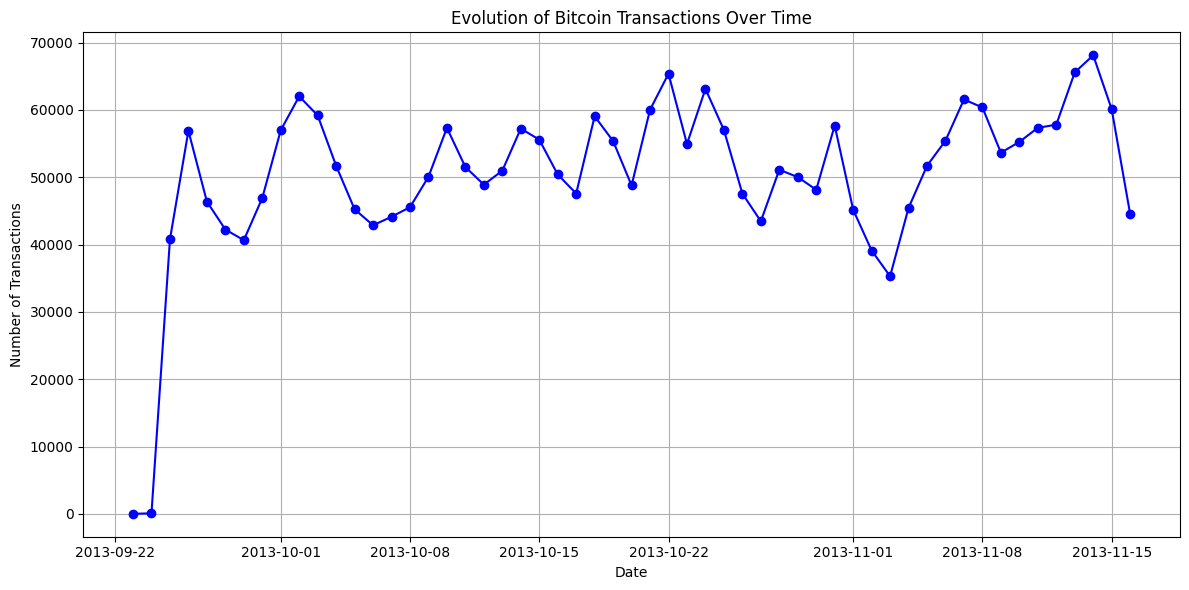

In [ ]:
transaction_counts_sdf = transactionSDF2.groupBy(F.to_date('Time').alias('Date')).count().orderBy('Date')

transaction_counts_pdf = transaction_counts_sdf.toPandas()

plt.figure(figsize=(12, 6))
plt.plot(transaction_counts_pdf['Date'], transaction_counts_pdf['count'], marker='o', linestyle='-', color='blue')
plt.title('Evolution of Bitcoin Transactions Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.grid(True)
plt.tight_layout()
plt.show()

### Evolution of currency transferred over time

Display a graph that shows the evolution of the amount of currency transferred (in BTC and USD) over time.


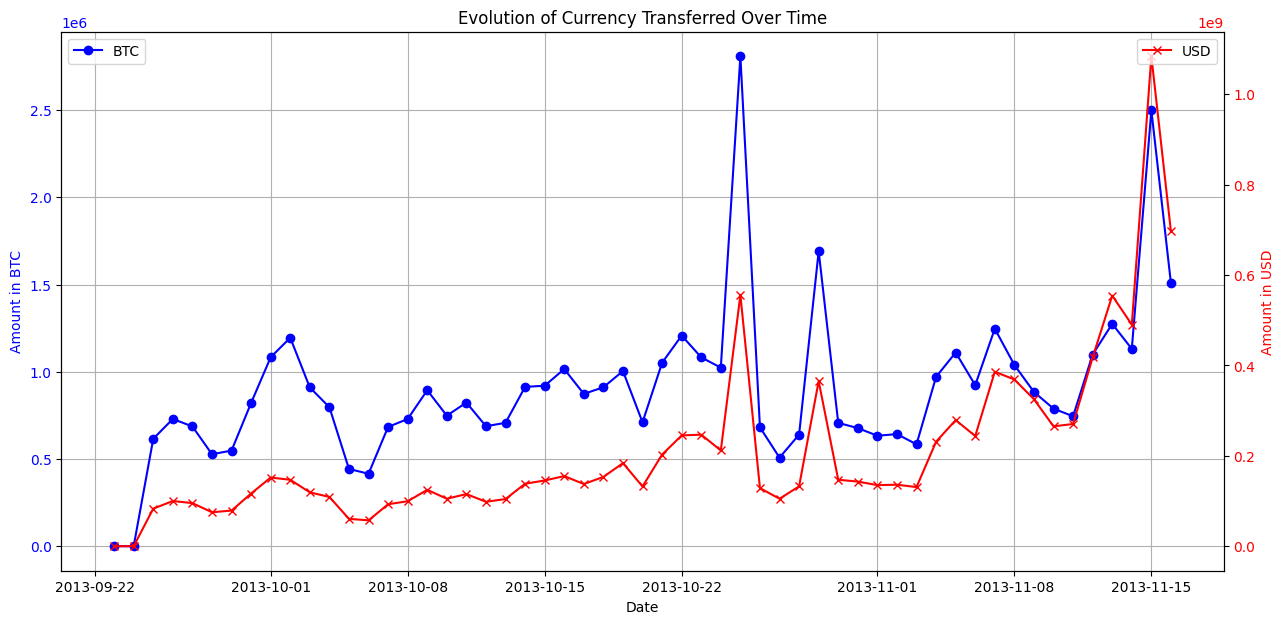

In [ ]:
btc_transferred_sdf = transactionSDF2.groupBy('Time').agg(F.sum('Sum').alias('TotalBTCTransferred'))

usd_transferred_sdf = merged_df.groupBy('Time').agg(F.sum('ValueUSD').alias('TotalUSDTransferred'))

btc_transferred_sdf = btc_transferred_sdf.orderBy('Time')
usd_transferred_sdf = usd_transferred_sdf.orderBy('Time')

btc_transferred_pdf = btc_transferred_sdf.toPandas()
usd_transferred_pdf = usd_transferred_sdf.toPandas()

fig, ax_btc = plt.subplots(figsize=(15, 7))

ax_btc.set_xlabel('Date')
ax_btc.set_ylabel('Amount in BTC', color='blue')
ax_btc.plot(btc_transferred_pdf['Time'], btc_transferred_pdf['TotalBTCTransferred'], color='blue', marker='o', linestyle='-', label='BTC')
ax_btc.tick_params(axis='y', labelcolor='blue')

ax_usd = ax_btc.twinx()
ax_usd.set_ylabel('Amount in USD', color='red')
ax_usd.plot(usd_transferred_pdf['Time'], usd_transferred_pdf['TotalUSDTransferred'], color='red', marker='x', linestyle='-', label='USD')
ax_usd.tick_params(axis='y', labelcolor='red')

plt.title('Evolution of Currency Transferred Over Time')
ax_btc.grid(True)

ax_btc.legend(loc='upper left')
ax_usd.legend(loc='upper right')

plt.show()

## Exercise 2 [4 points]

Assume you want to create a web site with infomration about bitcoin. In this website, a user could go and get some statistics for any Bitcoin address. You can select the statistics you want to maintain - you should maintain at least three statistics - suggestions: address account balance (mandatory); top-3 commercial partners; average transaction value.

To support this web site, it would be necessary to build one or more indices that would be used to answer the query of the user. In this context a index is a table that maps an address to a value of the statistics being computed.

Write the code to build these indices - for each index, print 5 lines.

**NOTE:** use the data from a single dataset file (even knowing that the value of the account balance would need to include processing all transactions).


####Account Balance Small Set

In [ ]:
inputDF = inputDF.rename(columns={"Input": "Address"})
outputDF = outputDF.rename(columns={"Output": "Address"})

unique_addresses = pd.concat([inputDF['Address'], outputDF['Address']]).unique()
balance_df = pd.DataFrame(unique_addresses, columns=['Address'])
balance_df['Balance'] = 0

inputDF['Order'] = inputDF.index
outputDF['Order'] = outputDF.index

last_input_tx = inputDF.groupby('Address').apply(lambda x: x.sort_values(by='Order', ascending=False).iloc[0])[['TxId', 'Order']]
last_input_tx.columns = ['LastInputTxId', 'LastInputOrder']
last_input_tx = last_input_tx.reset_index()

balance_df = pd.merge(balance_df, last_input_tx, on='Address', how='left')

addresses_in_input = set(inputDF['Address'])
addresses_in_output = set(outputDF['Address'])
addresses_in_both = addresses_in_input.intersection(addresses_in_output)

output_sum = outputDF.merge(balance_df, on='Address')
output_sum = output_sum[(output_sum['Address'].isin(addresses_in_both)) & (output_sum['Order'] > output_sum['LastInputOrder'].fillna(-1))]
output_sum = output_sum.groupby('Address')['Value'].sum().reset_index()

balance_df = pd.merge(balance_df, output_sum, on='Address', how='left')
balance_df.loc[balance_df['Address'].isin(addresses_in_both), 'Balance'] = balance_df['Value'].fillna(0)

addresses_only_in_output = addresses_in_output - addresses_in_input
output_sum_only = outputDF[outputDF['Address'].isin(addresses_only_in_output)].groupby('Address')['Value'].sum().reset_index()
balance_df = pd.merge(balance_df, output_sum_only, on='Address', how='left', suffixes=('', '_only_output'))
balance_df.loc[balance_df['Address'].isin(addresses_only_in_output), 'Balance'] = balance_df['Value_only_output'].fillna(0)

addresses_only_in_input = addresses_in_input - addresses_in_output
balance_df.loc[balance_df['Address'].isin(addresses_only_in_input), 'Balance'] = 0

balance_df.drop(['LastInputTxId', 'LastInputOrder', 'Value', 'Value_only_output'], axis=1, inplace=True)

print(balance_df.head(5))

                              Address  Balance
0  1DZTzaBHUDM7T3QvUKBz4qXMRpkg8jsfB5      1.0
1  1DCbY2GYVaAMCBpuBNN5GVg3a47pNK1wdi      0.0
2  1KAD5EnzzLtrSo2Da2G4zzD7uZrjk8zRAv      0.0
3  1DNdPgBZRWjDj1JbVZQEYMv7jvqJF7R4Py      0.0
4  1ELmSkQWnqgbBZNzxAZHts3MEYCngqRBeD      0.0


####top 3 output partners

In [ ]:
combinedDF = pd.merge(inputDF, outputDF, on=['TxId', 'Height'])

grouped = combinedDF.groupby(['Address_x', 'Address_y']).agg(
    Frequency=('TxId', 'count'),
    TotalValue=('Value', 'sum')
).reset_index()

grouped = grouped[grouped['Address_x'] != grouped['Address_y']]

grouped['Rank'] = grouped.groupby('Address_x')[['Frequency', 'TotalValue']].rank(method="first", ascending=False)['Frequency']

top3_partners = grouped[grouped['Rank'] <= 3]

top_partners_pivot = top3_partners.pivot(index='Address_x', columns='Rank', values='Address_y')

top_partners_pivot.columns = ['Top 1 Partner', 'Top 2 Partner', 'Top 3 Partner']

top_partners_pivot.reset_index(inplace=True)
top_partners_pivot.rename(columns={'Address_x': 'Address'}, inplace=True)

print(top_partners_pivot.head(5))

                              Address                       Top 1 Partner  \
0   111kzsNZ1w27kSGXwyov1ZvUGVLJMvLmJ  1Cp18yeabUg14CNp2HGwKisDoixiGgzmeT   
1  112EPnhrbSKKuc9sMdxxnCL4XAoXcfekzn  18gBZnsuSrhYLjvPUgwvDUJmksfREUGBTT   
2  112ETbnQDHvTG2XytkPUdzbTktGChcoNF3  1MPnG9XDjYqnq2Lz8SMq7H8ZHxadEQjSda   
3  112Kcj4anCh9StuAqaUDyLr7dfgPV3YwS9  15jJwkaxssfrq6jo82tRbHBorvfQ46GgpC   
4  112LNo8cZ3DbcJejrmTQ6SGJPa61bzLA75  15Z5YJaaNSxeynvr6uW6jQZLwq3n1Hu6RX   

                        Top 2 Partner Top 3 Partner  
0                                 NaN           NaN  
1  1JvL4YSx4YoDuwj99uqQQ3AisAyPC8Xx3p           NaN  
2                                 NaN           NaN  
3  1GwbQzDsyfe1UtADb8eR3R1y7HzKSVsGoX           NaN  
4                                 NaN           NaN  


####Average Transaction Amount#


considering only transaction where adress has recieved funds

In [ ]:
total_value_received = outputDF.groupby('Address')['Value'].sum()
count_received = outputDF.groupby('Address').size()
average_received_value = total_value_received / count_received

average_received_value = average_received_value.reset_index()
average_received_value.columns = ['Address', 'Average Received Value']

print(average_received_value.head(5))

                              Address Average Received Value
0  112797aokkr29PDoVE3Gu2VsSHPfa68eM7                   50.0
1  112EPnhrbSKKuc9sMdxxnCL4XAoXcfekzn                  25.39
2  112Kcj4anCh9StuAqaUDyLr7dfgPV3YwS9                   2.26
3  112TB1ebNuyWM4Y1v1CJzuZSmNXjCbVbD3                  26.94
4  112YQngrn5ta9CGbraDnerB7syaXKLJTz7                   5.77


### Discussion

###Calculating Account Balance

####Code Explanation
Our code to compute the accurate account balance begins with aligning the input and output datasets through consistent column naming, with 'Address' serving as the key identifier. After that, we created a new balance dataframe with a unique list of addresses from both datasets and set the starting balance to zero for each. We added a column called 'Order' to each transaction, which reflects its chronological position, so that transaction sequences could be accurately tracked. For every address, we determined the most recent input transaction, which is necessary to determine the current balance. We computed the balances of addresses that appeared in both datasets by adding up the output values, but only for transactions that came after the most recent input transaction. This made sure we only counted the money that was available. We calculated the balance of addresses that only appear in the output dataset by adding up all of their outputs. On the other hand, addresses that are only present in the input dataset—that is, addresses that have only sent but not received Bitcoin—were given a balance of zero. This distinction is crucial because it correctly captures the one-sided transactional character of these addresses, in which money has only ever left the account and left no balance behind. We made sure that our balance dataframe accurately reflected each address's financial situation in the Bitcoin transaction dataset by carefully adhering to these guidelines.


####Findings

The results of the Bitcoin transaction dataset analysis show a wide range of account balances, ranging from zero to significantly higher values. This variety suggests a mix of active and inactive market participants. Accounts with zero balances may represent inactive or outbound-only transaction activities, whereas those with higher balances may represent more powerful players, possibly the whale accounts previously identified. This balance distribution reveals the varied nature of market participation as well as the dynamic landscape of Bitcoin holdings. Our research focuses on how certain accounts may influence market trends and suggests a closer look at transaction histories and their consequences. It is important to note that our data used only includes transaction for a specific time period and does not contain transaction information on the full ledger. This means, while our findings are useful to detect address balances within our dataset, these numbers do not represent a real life account balance.


###Calculating Top 3 Partners

####Code Explanation

To identify the top three commercial partners for each Bitcoin address, we first combined the input and output dataframes on 'TxId' and 'Height,' resulting in a combined dataset. This dataset was divided into input and output address pairs, and the frequency and total value of transactions between them were calculated. To focus on external partnerships, we excluded pairs with the same input and output addresses. Then, for each input address, we ranked these pairs, identifying the top three partners based on transaction frequency. This ranking was reorganized into a clear table, with columns labeled 'Top 1 Partner,' 'Top 2 Partner,' and 'Top 3 Partner,' highlighting the most important commercial partners for each address. This process provided a structured view of the Bitcoin network's transactional relationships, highlighting the key partners for each address in our dataset.

####Findings

It is particularly interesting to observe patterns of engagement between accounts in our analysis of the Bitcoin transaction dataset. As shown in the 'Top 1 Partner' column, we discovered that several addresses primarily transact with a single commercial partner. This discovery is intriguing because it reveals the network's primary transactional connections. While some addresses have additional partnerships in the 'Top 2' and 'Top 3' partner columns, a significant number have 'NaN' entries, implying either exclusive transactional relationships or the dataset's limited time frame. The presence of these focused partnerships highlights the diverse nature of transactional behaviors in the Bitcoin network, as well as the importance of understanding which accounts engage with each other the most.

###Average Transaction Value

####Code Explanation

We calculated the average transaction value for each Bitcoin address in our code, focusing on transactions where each address received funds. We started by categorizing our output data frame, outputDF, by 'Address' and then adding the 'Value' column for each address. This step gave us the total amount received per address. Then we computed the total number of recieving transactions as well as the average value reciever per transaction for each address. This step enabled us to calculate the average value received by dividing the total value received by the number of transactions. The results were then formatted for clarity by resetting the index and renaming the columns 'Bitcoin Address' and 'Average Received Value'. We were able to clearly display the average transaction value as a result of this.

####Rationale

Bitcoin transaction vary greatly in terms of transaction values, especially when analyzing the average transaction value in recievings. This shows that people use Bitcoin for different purposes. While some addresses engange in large-scale transactions, others use it only for minor transactions. Understanding this differences is crucial to comprehend how the Bitcoin network operates and how different players influence the network by their activity.


## Exercise 3 [4 points]

Explore the creation of classification models for assigning labels to addresses. Use the labels assigned in the provided dataset for training and testing.

**SUGGESTION:** use statistics associated with each address, including number of transactions, avergae amount of transactions, average number of partners per day (or other time unit), etc.

**NOTE:** building the best classification model is a never ending task, and we do not expect you to build a perfect classifier. What we expect you in this task is that you propose a set of variables and explain the relevance of such variable for helping differentiate between different classes, and that do the step to build and evaluate the classifier.


### Import Libraries for Exercise 3 & 4

In [ ]:
import seaborn

from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

### Load Label Dataset

In [ ]:
LABEL_DATASET_DIR = "/content/drive/MyDrive/sbe2324ada/labels"
LABEL_DATA_FILE = "labels-260001-270000.csv.gz"


path = os.path.join(LABEL_DATASET_DIR, LABEL_DATA_FILE)
label_df = pd.read_csv( path,compression="gzip")
label_df.head()

address                 name  \
0  '1123Xk35ETmk9ZRt3aWn8ZA53qaGLFaatq'          BitZino.com   
1  '112EXhpBUYZgG8kcMQGZGxsjLhY53XABgN'           BitcoinFog   
2  '112Rx6rV6qeZNQCZhM44EJcMEej3U2dDU3'     SheepMarketplace   
3  '112T1UcsBoDqRniALumagwmBCYTCzWj1qT'  SatoshiRoulette.com   
4  '112nyuEiSnMCR9PxFf6t5LFve2Lm9R7y5S'     SheepMarketplace   

              date_first_tx      type  country  
0  2013-10-23T02:58:56.000Z  gambling  unknown  
1  2013-10-28T18:10:56.000Z   service  unknown  
2  2013-10-19T14:32:34.000Z  historic  unknown  
3  2013-10-27T00:41:13.000Z  gambling  unknown  
4  2013-11-08T11:07:10.000Z  historic  unknown

### Data Analysis

In [ ]:
label_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258476 entries, 0 to 258475
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   address        258476 non-null  object
 1   name           258476 non-null  object
 2   date_first_tx  258476 non-null  object
 3   type           258476 non-null  object
 4   country        258476 non-null  object
dtypes: object(5)
memory usage: 9.9+ MB


In [ ]:
label_df["country"].value_counts().head()

unknown    214067
CANADA      22360
UK          10931
CHINA        5562
AUSTRIA      1392
Name: country, dtype: int64

In [ ]:
label_df["name"].nunique()

90

### Data Cleaning

In [ ]:
label_df['address'] = label_df['address'].str[1:-1]
label_df.head()

address                 name  \
0  1123Xk35ETmk9ZRt3aWn8ZA53qaGLFaatq          BitZino.com   
1  112EXhpBUYZgG8kcMQGZGxsjLhY53XABgN           BitcoinFog   
2  112Rx6rV6qeZNQCZhM44EJcMEej3U2dDU3     SheepMarketplace   
3  112T1UcsBoDqRniALumagwmBCYTCzWj1qT  SatoshiRoulette.com   
4  112nyuEiSnMCR9PxFf6t5LFve2Lm9R7y5S     SheepMarketplace   

              date_first_tx      type  country  
0  2013-10-23T02:58:56.000Z  gambling  unknown  
1  2013-10-28T18:10:56.000Z   service  unknown  
2  2013-10-19T14:32:34.000Z  historic  unknown  
3  2013-10-27T00:41:13.000Z  gambling  unknown  
4  2013-11-08T11:07:10.000Z  historic  unknown

### Feature Engineering

#### Basic Statistics for outputDF (Max, Min, Median, Mean Transaction Value)

In [ ]:
address_stats = outputDF2.groupby('Output')['Value'].agg(['mean', 'median', 'max', 'min'])
address_stats.head()

mean  median     max     min
Output                                                         
1111111111111111111114oLvT2    0.000102  0.0001  0.0003  0.0001
1111111111111111114hC5DWZkt9   0.000100  0.0001  0.0001  0.0001
1111111111111116UYmRBuMPBX82M  0.000100  0.0001  0.0001  0.0001
1111111111111117NfxiuJZGr5XXB  0.000100  0.0001  0.0001  0.0001
1111111111111117NjepKDWv4w27o  0.000100  0.0001  0.0001  0.0001

#### Account Balance Large Set

In [ ]:
inputDF2 = inputDF2.rename(columns={"Input": "Address"})
outputDF2 = outputDF2.rename(columns={"Output": "Address"})

unique_addresses = pd.concat([inputDF2['Address'], outputDF2['Address']]).unique()
balance_df = pd.DataFrame(unique_addresses, columns=['Address'])
balance_df['Balance'] = 0

inputDF2['Order'] = inputDF2.index
outputDF2['Order'] = outputDF2.index

last_input_tx = inputDF2.groupby('Address').apply(lambda x: x.sort_values(by='Order', ascending=False).iloc[0])[['TxId', 'Order']]
last_input_tx.columns = ['LastInputTxId', 'LastInputOrder']
last_input_tx = last_input_tx.reset_index()

balance_df = pd.merge(balance_df, last_input_tx, on='Address', how='left')

addresses_in_input = set(inputDF2['Address'])
addresses_in_output = set(outputDF2['Address'])
addresses_in_both = addresses_in_input.intersection(addresses_in_output)

output_sum = outputDF2.merge(balance_df, on='Address')
output_sum = output_sum[(output_sum['Address'].isin(addresses_in_both)) & (output_sum['Order'] > output_sum['LastInputOrder'].fillna(-1))]
output_sum = output_sum.groupby('Address')['Value'].sum().reset_index()

balance_df = pd.merge(balance_df, output_sum, on='Address', how='left')
balance_df.loc[balance_df['Address'].isin(addresses_in_both), 'Balance'] = balance_df['Value'].fillna(0)

addresses_only_in_output = addresses_in_output - addresses_in_input
output_sum_only = outputDF2[outputDF2['Address'].isin(addresses_only_in_output)].groupby('Address')['Value'].sum().reset_index()
balance_df = pd.merge(balance_df, output_sum_only, on='Address', how='left', suffixes=('', '_only_output'))
balance_df.loc[balance_df['Address'].isin(addresses_only_in_output), 'Balance'] = balance_df['Value_only_output'].fillna(0)

addresses_only_in_input = addresses_in_input - addresses_in_output
balance_df.loc[balance_df['Address'].isin(addresses_only_in_input), 'Balance'] = 0

balance_df.drop(['LastInputTxId', 'LastInputOrder', 'Value', 'Value_only_output'], axis=1, inplace=True)

In [ ]:
balance_df.set_index("Address", inplace=True)
balance_df.index.name = None
balance_df.head()

Balance
16NsFTH1jYxHjNrHQ5aBGspxpgxSohccL5      0.0
1LSwMGAcuqgdxUJWvRkQ65kY4uJupm2LeV      0.0
1Jb54qdm8VUwNv5q47hqg27gEQXGT1MD3W      0.0
1G2sovDQyC2aEDjaaBNWnfrapYeoDNERhS      0.0
18szc8Q5QuUcH2AMREX87ggy31Xp8x2dTu      0.0

#### Average Output Transaction Amount per Address

In [ ]:
total_value_received = outputDF2.groupby('Address')['Value'].sum()
count_received = outputDF2.groupby('Address').size()
average_received_value = total_value_received / count_received
average_received_value = average_received_value.reset_index().rename(columns={'Address': 'Bitcoin Address', 0: 'Average Received Value'})
average_received_value.set_index('Bitcoin Address', inplace=True)
average_received_value.index.name = None
average_received_value.head()

Average Received Value
1111111111111111111114oLvT2                 0.000102
1111111111111111114hC5DWZkt9                  0.0001
1111111111111116UYmRBuMPBX82M                 0.0001
1111111111111117NfxiuJZGr5XXB                 0.0001
1111111111111117NjepKDWv4w27o                 0.0001

#### Amount of Transactions per Address

In [ ]:
addr2.head()

cnt_in  cnt_out    cnt
1111111111111111111114oLvT2       0.0    168.0  168.0
1111111111111111114hC5DWZkt9      0.0      1.0    1.0
1111111111111116UYmRBuMPBX82M     0.0      1.0    1.0
1111111111111117NfxiuJZGr5XXB     0.0      1.0    1.0
1111111111111117NjepKDWv4w27o     0.0      1.0    1.0

#### Average number of Input Transactions per Month per Address



In [ ]:
inputDF2['Time'] = pd.to_datetime(inputDF2['Time'])
inputDF2['Year_Month'] = inputDF2['Time'].dt.to_period('M')
transactions_per_month = inputDF2.groupby(['Address', 'Year_Month']).size().reset_index(name='Avg_Trans_Per_Month_Input')
average_transactions_per_month = transactions_per_month.groupby('Address')['Avg_Trans_Per_Month_Input'].mean().to_frame()

average_transactions_per_month.index.name = None
average_transactions_per_month.head()

Avg_Trans_Per_Month_Input
1111135jHBPwasM92ub4mK6awHKUiTPwq                        2.0
111113xXyHALVNzX9S2NdW1GA5Sz1UxWM                        1.0
11117uHSkwU2wwf7uy2ds96S6YEVapCRe                        1.0
1111Cqysd7sqfvfCCWteJfkuB9wMMmTBB                        1.5
1111EJcQNL9hGYf1qDoQWh6JChBZFSYU4                        2.5

#### Average number of Output Transactions per Month per Address

In [ ]:
outputDF2['Time'] = pd.to_datetime(outputDF2['Time'])
outputDF2['Year_Month'] = outputDF2['Time'].dt.to_period('M')
transactions_per_month_output = outputDF2.groupby(['Address', 'Year_Month']).size().reset_index(name='Avg_Trans_Per_Month_Output')
average_transactions_per_month_output = transactions_per_month_output.groupby('Address')['Avg_Trans_Per_Month_Output'].mean().to_frame()

average_transactions_per_month_output.index.name = None
average_transactions_per_month_output.head()

Avg_Trans_Per_Month_Output
1111111111111111111114oLvT2                          84.0
1111111111111111114hC5DWZkt9                          1.0
1111111111111116UYmRBuMPBX82M                         1.0
1111111111111117NfxiuJZGr5XXB                         1.0
1111111111111117NjepKDWv4w27o                         1.0

#### Age of Account

In [ ]:
inputDF2['Time'] = pd.to_datetime(inputDF2['Time'])
outputDF2['Time'] = pd.to_datetime(outputDF2['Time'])

combinedDF = pd.concat([inputDF2, outputDF2])

age_of_account = combinedDF.groupby('Address')['Time'].agg(['min', 'max'])
age_of_account['Age_of_Account'] = (age_of_account['max'] - age_of_account['min']).dt.days
age_of_account.value_counts("Age_of_Account").head()

Age_of_Account
0    2470372
1     118139
2      53335
3      33301
4      26412
dtype: int64

#### Number of Unique Total Interaction Addresses per Address

In [ ]:
inputDF2_renamed = inputDF2.rename(columns={"Address": "Input"})
outputDF2_renamed = outputDF2.rename(columns={"Address": "Output"})

In [ ]:
direct_interactions = pd.merge(inputDF2_renamed, outputDF2_renamed, on='TxId')

unique_input_partners = inputDF2_renamed[inputDF2_renamed['Input'] != inputDF2_renamed['TxId']].groupby('Input')['TxId'].nunique()
unique_output_partners = outputDF2_renamed[outputDF2_renamed['Output'] != outputDF2_renamed['TxId']].groupby('Output')['TxId'].nunique()

direct_input_partners = direct_interactions[direct_interactions['Input'] != direct_interactions['Output']].groupby('Input')['Output'].nunique()
direct_output_partners = direct_interactions[direct_interactions['Output'] != direct_interactions['Input']].groupby('Output')['Input'].nunique()

total_unique_partners = unique_input_partners.add(unique_output_partners, fill_value=0)
total_unique_partners = total_unique_partners.add(direct_input_partners, fill_value=0)
total_unique_partners = total_unique_partners.add(direct_output_partners, fill_value=0)

total_unique_partners_df = total_unique_partners.reset_index()
total_unique_partners_df.columns = ['Address', 'Number of Unique Partners']

print("Number of Unique Partners for Each Address:")
print(total_unique_partners_df.head(5))


Number of Unique Partners for Each Address:
                         Address  Number of Unique Partners
0    1111111111111111111114oLvT2                      208.0
1   1111111111111111114hC5DWZkt9                        2.0
2  1111111111111116UYmRBuMPBX82M                        2.0
3  1111111111111117NfxiuJZGr5XXB                        2.0
4  1111111111111117NjepKDWv4w27o                        2.0


In [ ]:
total_unique_partners_df.set_index("Address", inplace=True)
total_unique_partners_df.index.name = None
total_unique_partners_df.head()

Number of Unique Partners
1111111111111111111114oLvT2                        208.0
1111111111111111114hC5DWZkt9                         2.0
1111111111111116UYmRBuMPBX82M                        2.0
1111111111111117NfxiuJZGr5XXB                        2.0
1111111111111117NjepKDWv4w27o                        2.0

### Building the Dataset

In [ ]:
label_df.set_index("address", inplace=True, drop=False)
label_df.index.name = None
label_df.head()

address  \
1123Xk35ETmk9ZRt3aWn8ZA53qaGLFaatq  1123Xk35ETmk9ZRt3aWn8ZA53qaGLFaatq   
112EXhpBUYZgG8kcMQGZGxsjLhY53XABgN  112EXhpBUYZgG8kcMQGZGxsjLhY53XABgN   
112Rx6rV6qeZNQCZhM44EJcMEej3U2dDU3  112Rx6rV6qeZNQCZhM44EJcMEej3U2dDU3   
112T1UcsBoDqRniALumagwmBCYTCzWj1qT  112T1UcsBoDqRniALumagwmBCYTCzWj1qT   
112nyuEiSnMCR9PxFf6t5LFve2Lm9R7y5S  112nyuEiSnMCR9PxFf6t5LFve2Lm9R7y5S   

                                                   name  \
1123Xk35ETmk9ZRt3aWn8ZA53qaGLFaatq          BitZino.com   
112EXhpBUYZgG8kcMQGZGxsjLhY53XABgN           BitcoinFog   
112Rx6rV6qeZNQCZhM44EJcMEej3U2dDU3     SheepMarketplace   
112T1UcsBoDqRniALumagwmBCYTCzWj1qT  SatoshiRoulette.com   
112nyuEiSnMCR9PxFf6t5LFve2Lm9R7y5S     SheepMarketplace   

                                               date_first_tx      type  \
1123Xk35ETmk9ZRt3aWn8ZA53qaGLFaatq  2013-10-23T02:58:56.000Z  gambling   
112EXhpBUYZgG8kcMQGZGxsjLhY53XABgN  2013-10-28T18:10:56.000Z   service   
112Rx6rV6qeZNQCZhM44EJcMEej3U2dDU3  2013-10-19T14:32:34.000Z  historic   
112T1UcsBoDqRniALumagwmBCYTCzWj1qT  2013-10-27T00:41:13.000Z  gambling   
112nyuEiSnMCR9PxFf6t5LFve2Lm9R7y5S  2013-11-08T11:07:10.000Z  historic   

                                    country  
1123Xk35ETmk9ZRt3aWn8ZA53qaGLFaatq  unknown  
112EXhpBUYZgG8kcMQGZGxsjLhY53XABgN  unknown  
112Rx6rV6qeZNQCZhM44EJcMEej3U2dDU3  unknown  
112T1UcsBoDqRniALumagwmBCYTCzWj1qT  unknown  
112nyuEiSnMCR9PxFf6t5LFve2Lm9R7y5S  unknown

In [ ]:
class_df = pd.merge(label_df, address_stats, left_index=True, right_index=True, how="left")

class_df = pd.merge(class_df, balance_df, left_index=True, right_index=True, how="left")

class_df = pd.merge(class_df, average_received_value, left_index=True, right_index=True, how="left")

class_df = pd.merge(class_df, addr2, left_index=True, right_index=True, how="left")

class_df = pd.merge(class_df, average_transactions_per_month, left_index=True, right_index=True, how="left")

class_df = pd.merge(class_df, average_transactions_per_month_output, left_index=True, right_index=True, how="left")

class_df = class_df.fillna(0)

class_df = pd.merge(class_df, age_of_account["Age_of_Account"], left_index=True, right_index=True, how="left")

class_df = pd.merge(class_df, total_unique_partners_df, left_index=True, right_index=True, how="left")

In [ ]:
class_df.isna().sum()

address                       0
name                          0
date_first_tx                 0
type                          0
country                       0
mean                          0
median                        0
max                           0
min                           0
Balance                       0
Average Received Value        0
cnt_in                        0
cnt_out                       0
cnt                           0
Avg_Trans_Per_Month_Input     0
Avg_Trans_Per_Month_Output    0
Age_of_Account                0
Number of Unique Partners     0
dtype: int64

In [ ]:
class_df.corr()

<ipython-input-62-56337df0ae23>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  class_df.corr()


mean    median       max       min   Balance  \
mean                        1.000000  0.990006  0.648296  0.806014  0.094375   
median                      0.990006  1.000000  0.592712  0.814796  0.094499   
max                         0.648296  0.592712  1.000000  0.356033  0.068835   
min                         0.806014  0.814796  0.356033  1.000000  0.096512   
Balance                     0.094375  0.094499  0.068835  0.096512  1.000000   
Average Received Value      1.000000  0.990006  0.648296  0.806014  0.094375   
cnt_in                     -0.000238 -0.000787  0.009408 -0.001595 -0.000074   
cnt_out                    -0.000683 -0.001049  0.008685 -0.001577  0.001449   
cnt                        -0.000525 -0.000975  0.009234 -0.001631  0.000883   
Avg_Trans_Per_Month_Input   0.000057 -0.000583  0.009714 -0.001789 -0.000335   
Avg_Trans_Per_Month_Output -0.000354 -0.000795  0.008867 -0.001732  0.002098   
Age_of_Account              0.000956  0.000009  0.007070 -0.006657  0.002255   
Number of Unique Partners   0.002221  0.000302  0.022141 -0.001176  0.001730   

                            Average Received Value    cnt_in   cnt_out  \
mean                                      1.000000 -0.000238 -0.000683   
median                                    0.990006 -0.000787 -0.001049   
max                                       0.648296  0.009408  0.008685   
min                                       0.806014 -0.001595 -0.001577   
Balance                                   0.094375 -0.000074  0.001449   
Average Received Value                    1.000000 -0.000238 -0.000683   
cnt_in                                   -0.000238  1.000000  0.879570   
cnt_out                                  -0.000683  0.879570  1.000000   
cnt                                      -0.000525  0.954091  0.981691   
Avg_Trans_Per_Month_Input                 0.000057  0.993157  0.878464   
Avg_Trans_Per_Month_Output               -0.000354  0.871042  0.988765   
Age_of_Account                            0.000956  0.036011  0.014331   
Number of Unique Partners                 0.002221  0.944827  0.945678   

                                 cnt  Avg_Trans_Per_Month_Input  \
mean                       -0.000525                   0.000057   
median                     -0.000975                  -0.000583   
max                         0.009234                   0.009714   
min                        -0.001631                  -0.001789   
Balance                     0.000883                  -0.000335   
Average Received Value     -0.000525                   0.000057   
cnt_in                      0.954091                   0.993157   
cnt_out                     0.981691                   0.878464   
cnt                         1.000000                   0.950655   
Avg_Trans_Per_Month_Input   0.950655                   1.000000   
Avg_Trans_Per_Month_Output  0.971204                   0.885143   
Age_of_Account              0.023439                   0.024753   
Number of Unique Partners   0.973619                   0.946725   

                            Avg_Trans_Per_Month_Output  Age_of_Account  \
mean                                         -0.000354        0.000956   
median                                       -0.000795        0.000009   
max                                           0.008867        0.007070   
min                                          -0.001732       -0.006657   
Balance                                       0.002098        0.002255   
Average Received Value                       -0.000354        0.000956   
cnt_in                                        0.871042        0.036011   
cnt_out                                       0.988765        0.014331   
cnt                                           0.971204        0.023439   
Avg_Trans_Per_Month_Input                     0.885143        0.024753   
Avg_Trans_Per_Month_Output                    1.000000        0.014603   
Age_of_Account                                0

<ipython-input-63-b3f0b50ae1a1>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = class_df.corr()


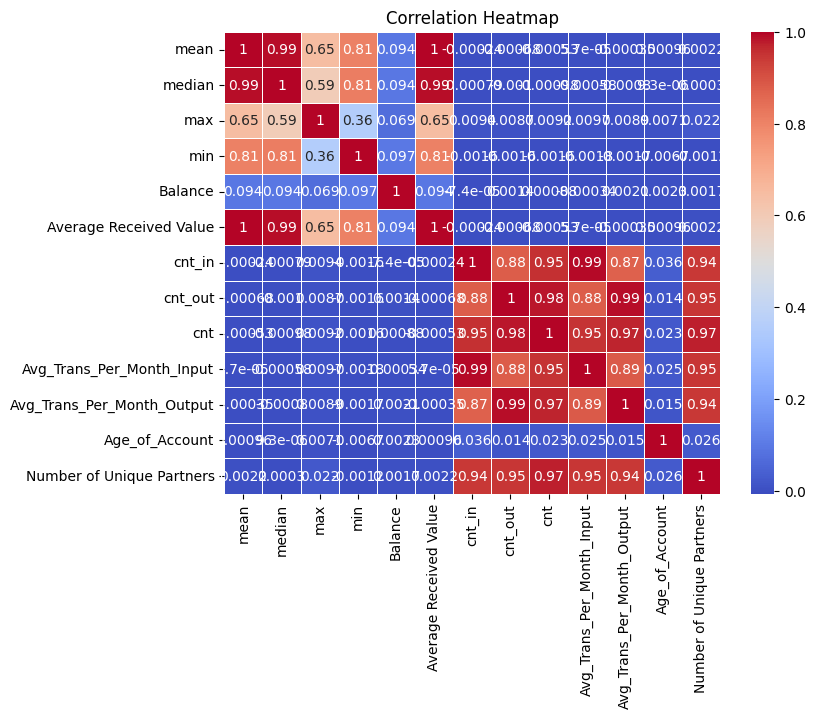

In [ ]:
correlation_matrix = class_df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

Within the correlation matrix, numerous variables exhibit a substantial correlation, such as the relationship between Avg_Trans_Per_Month_Input and cnt_in or Average Received Value and min. This presents a challenge for the classification task because it indicates redundancy among variables, essentially implying that these variables convey similar information. This redundancy poses several issues, including increased computational load from unnecessary data and a significant influence on the model by the overlapping information held within the variables. Consequently, we opted to decrease the feature set by excluding those with strong correlations among them.

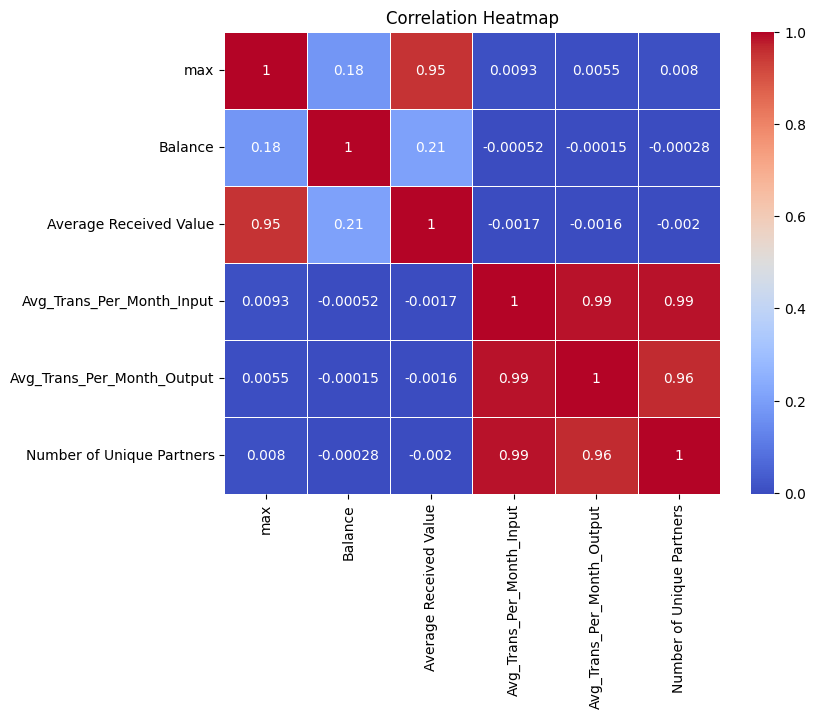

In [ ]:
correlation_matrix = class_df[["max","Balance","Average Received Value","Avg_Trans_Per_Month_Input","Avg_Trans_Per_Month_Output","Number of Unique Partners"]].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
class_df["type"].value_counts()

historic     117667
service       84601
exchanges     44409
gambling      11113
mining          686
Name: type, dtype: int64

In [ ]:
historic_df = class_df[class_df['type'] == 'historic'].sample(7000, replace=True)
service_df = class_df[class_df['type'] == 'service'].sample(7000, replace=True)
exchanges_df = class_df[class_df['type'] == 'exchanges'].sample(7000, replace=True)
gambling_df = class_df[class_df['type'] == 'gambling'].sample(7000, replace=True)
mining_df = class_df[class_df['type'] == 'mining']

new_dataset = pd.concat([historic_df, service_df, exchanges_df, gambling_df, mining_df])
new_dataset.reset_index(drop=True, inplace=True)

print(new_dataset['type'].value_counts())

historic     7000
service      7000
exchanges    7000
gambling     7000
mining        686
Name: type, dtype: int64


In [ ]:
class_df = new_dataset.sample(frac=1, random_state=42)

In [ ]:
# divide in X and y
y = class_df["type"]
y_small = class_df["type"].iloc[:int(len(class_df) * 0.1)]


X = class_df[["max","Balance","Average Received Value","Avg_Trans_Per_Month_Input","Avg_Trans_Per_Month_Output","Number of Unique Partners"]]
X_small = class_df[["max","Balance","Average Received Value","Avg_Trans_Per_Month_Input","Avg_Trans_Per_Month_Output","Number of Unique Partners"]].iloc[:int(len(class_df) * 0.1)]

### Classification

#### KNeighbors Classifier

In [ ]:
scaler = StandardScaler()

X_small_scaled_class = scaler.fit_transform(X_small)
X_scaled_class = scaler.fit_transform(X)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)

scoring_metrics = ['accuracy', 'precision_macro', 'recall_macro']

for metric in scoring_metrics:
    scores = cross_val_score(knn, X_scaled_class, y, cv=10, scoring=metric)
    print(f'Scoring metric: {metric}')
    print(f'Scores: {scores}')
    print(f'Mean {metric}: {scores.mean():.4f}\n')

Scoring metric: accuracy
Scores: [0.60787731 0.63088184 0.61345417 0.63157895 0.63924712 0.64796096
 0.62866109 0.62761506 0.63354254 0.63493724]
Mean accuracy: 0.6296

Scoring metric: precision_macro
Scores: [0.62614118 0.66884967 0.62088807 0.65237501 0.64894451 0.67366646
 0.64435665 0.65532631 0.63986773 0.64724063]
Mean precision_macro: 0.6478

Scoring metric: recall_macro
Scores: [0.5975735  0.60336646 0.59953209 0.61438923 0.61544928 0.61475362
 0.61339496 0.63378151 0.61739496 0.61322689]
Mean recall_macro: 0.6123



#### Discussion

**Load Label Dataset**

Based on the large dataset initially imported for our exercise and utilized for computing statistics, we imported the labeled dataset named "labels-260001-270000.csv.gz."

**Data Analysis & Cleaning**

80% of the entries within the "country" column are absent, rendering it unusable for our machine learning objectives due to the extensive missing data.

The "name" column contains 90 distinct values, and incorporating these would generate a substantial number of dummy variables. Our analyses demonstrated that the "name" column significantly contributes valuable information for the classification process. However, as previously discussed in our class, we have decided against employing it for classification purposes.

Minor data cleaning activities were neccessary to be able to use the dataset, for example the extra '' in the "address" column needed to be fixed.

**Feature Engineering**

For the classification task on hand we decided to calculate more statistics regarding the dataset. The features we calculated are the:
* max, min, median and mean of the values from the outputDF
* Account Balances
* Average Output Transaction Amount for each address
* Amount of Transactions for each address
* Average number of Input Transactions per Month for each address
* Average number of Output Transactions per Month for each address
* Age of the Account (address)
* Number of Unique Total Interaction Addresses for each address

More detailed explaination of the features:

*max, min, median, mean:* The data is grouped by the column labeled 'Output' and computes several aggregate statistics (mean, median, maximum, minimum) on the values in the 'Value' column within each group.

*Account Balances:* To calculate the account balance we assumed that all balances prior to the beginning of our dataset are 0. To calculate the balance we searched for the last instance of a certain address in the "Input" column of the inputDF. From there we summed up all "Values" from this address in the outputDF. For addresses soley apparent in the inputDF the balance is set to 0, according to the way btc transactions are conducted. All coins are sent in every input transaction.

*Average Output Transaction Amount:* The code computes the average value received for each address by dividing the total value received by the count of transactions. This is achieved by grouping each address and summing up its value and dividing by the size of each group

*Amount of Transactions per Address:* was pre-computed at the beginning of the exercise

*Average Number of Input Transaction per Month (same code for output transactions):* The code creates a new column named 'Year_Month' in the inputDF DataFrame. Next, the code groups the DataFrame inputDF2 by both 'Address' and 'Year_Month' columns. It counts the occurrences of each unique combination of 'Address' and 'Year_Month'.

*Age of the Account:* First, inputDF and outputDF are combined and then the difference in days between the first and the last occurence of a certain address is computed.

*Number of Unique Total Interaction Addresses:* The code aims to compute how many unique transaction partners each address has. Not counting itself, if an input sends itself btc in the output transaction. InputDF and outputDF are combined. Then, it calculates unique partners for input and output separately in various scenarios - 'unique_input_partners' and 'unique_output_partners' count distinct 'TxId's for each 'Input' and 'Output'. Additionally, it computes direct partners for inputs and outputs in 'direct_interactions', counting distinct 'Output' partners for each 'Input' and vice versa.

**Building the Dataset**

In the first step every feature was merged with the provided label dataset. Then we wanted to find out if certain features might correlate amongst each other. Removing variables with high correlation in machine learning is essential because highly correlated variables can negatively impact the model's performance and stability. When two variables are highly correlated, they convey similar information to the model, leading to redundancy. This redundancy can cause issues like multicollinearity, where the model finds it challenging to distinguish between the effects of correlated features. By eliminating highly correlated variables, we reduce redundanc and improve the model's efficiency. Furthermore, this enhances its ability to generalize patterns to new data, hopefully leading to better predictions and more reliable insights.

We depicted this by generating a correlation heatmap. Upon conducting performance tests using various feature combinations and excluding highly correlated features, we retained the subsequent features ["max", "Balance", "Average Received Value","Avg_Trans_Per_Month_Input", "Avg_Trans_Per_Month_Output",
"Number of Unique Partners"]. Despite a substantial correlation between the Number of Unique Addresses and the Average number of Input/Output Transactions, we retained them to maintain the temporal aspect within the dataset. However, we had to eliminate the Age of Transaction due to numerous instances where transactions occurred only once in the dataset. This led to multiple instances of zero values when filling in missing data.

In the subsequent step, we scrutinized the label distribution within our dataset and observed a significant imbalance among historic, services, gambling, exchanges, and mining data. This discrepancy can pose challenges for subsequent classification and clustering tasks. Balanced data leads to fairer model training and evaluation. This removes biases by ensuring even representation of classes, resulting in heightened accuracy and robustness.

To address this issue, we sampled approximately 7000 rows for historic, services, gambling, and exchange data, and the entire mining data (around 1000 rows). Although a gap persists between the mining label and others, this sampling approach aims to mitigate the disparity.

**Classificaton**

For the classification task, we opted for the KNeighbors Classifier for several reasons: its lightweight calculations, simplicity, and effectiveness, especially with smaller datasets.

To assess the classification outcomes, we selected three parameters:

- *Accuracy:* This measures the overall correctness of predictions.
- *Precision:* It evaluates the accuracy of positive predictions.
- *Recall:* Measures the model's capability to identify all positive instances.

The scores obtained were approximately 63% for accuracy, 65% for precision, and 61% for recall. Although these scores might seem relatively low, their similarity is encouraging, suggesting a well-balanced model. This alignment indicates that the model is performing well in predicting overall correctness, positive instances accuracy, and capturing relevant positive instances.

If enhancements were required for our classification, we would focus on improving our features. Many features contained numerous zero values due to the incomplete nature of the dataset (representing not all BTC transactions). Our strategy would involve seeking additional features and gathering more data for the 'mining' label. Additionally, experimenting with more sophisticated classification algorithms such as Random Forests, Support Vector Machines, or Deep Learning models could be explored.


## Exercise 4 [4 points]

Consider we didn't have the labels for the address, but that you would want to create groups of addresses. Propose a solution.


### Proposed Solution

Since we don't have labels for the addresses but want to create groups based on certain similarities or patterns within the data, we can use unsupervised learning techniques, such as clustering algorithms.

### Building the Dataset

In [ ]:
data = {
    'Labels': ['historic', 'service', 'exchanges', 'gambling', 'mining'],
    'Count': [7000, 7000, 7000, 7000, 686]
}

label_numbers = {
    'historic': 0,
    'service': 1,
    'exchanges': 2,
    'gambling': 3,
    'mining': 4
}

new_dataset['Label_Numbers'] = new_dataset['type'].map(label_numbers)

In [ ]:
cluster_df = new_dataset.sample(frac=1, random_state=42)

In [ ]:
cluster_y = cluster_df[["Label_Numbers"]]
cluster_df = cluster_df[["max","Balance","Average Received Value","Avg_Trans_Per_Month_Input","Avg_Trans_Per_Month_Output","Number of Unique Partners"]]
cluster_df_small = cluster_df[["max","Balance","Average Received Value","Avg_Trans_Per_Month_Input","Avg_Trans_Per_Month_Output","Number of Unique Partners"]].iloc[:int(len(class_df) * 0.1)]

In [ ]:
cluster_df_scaled_small = scaler.fit_transform(cluster_df_small)
cluster_df_scaled = scaler.fit_transform(cluster_df)

### Finding the Right Amount of Clusters

####t-SNE

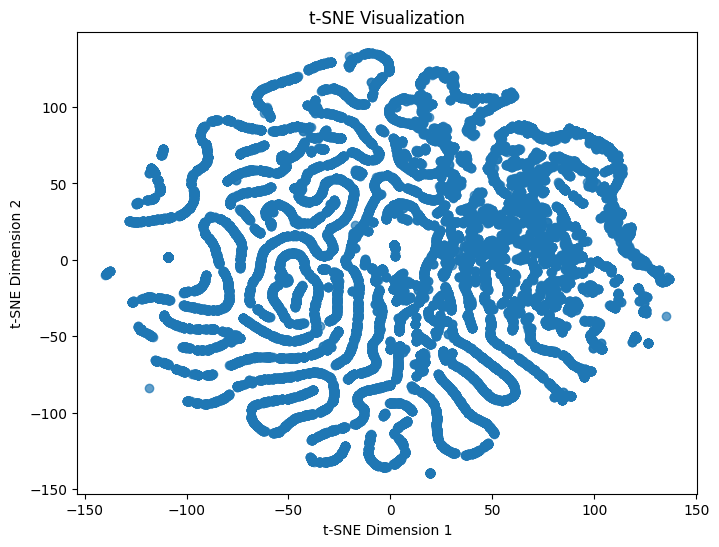

In [ ]:
tsne = TSNE(n_components=2, random_state=42)

X_embedded = tsne.fit_transform(cluster_df)

# Plot the t-SNE embedding
plt.figure(figsize=(8, 6))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], alpha=0.7)
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()


#### Elbow Method

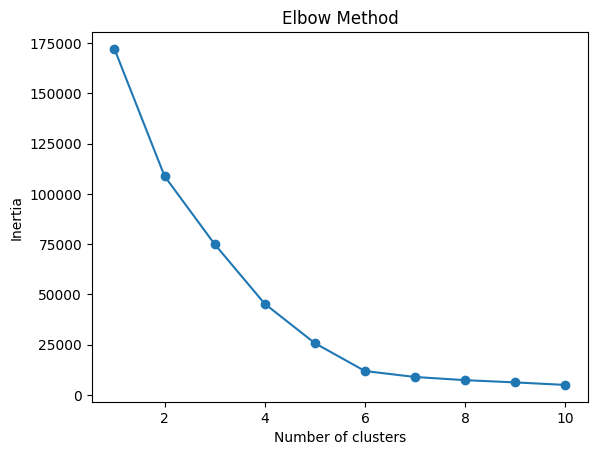

In [ ]:
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(cluster_df_scaled)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow Method graph
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

####Silhouette value

<Axes: xlabel='num'>

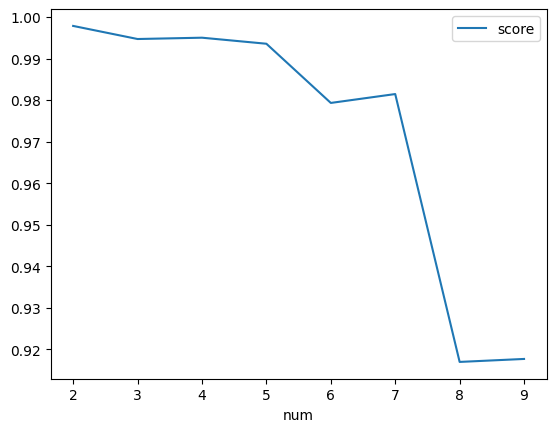

In [ ]:
def evaluate( dataset, k):
    kmeans = KMeans(n_clusters = k, n_init='auto')
    labels = kmeans.fit_predict(dataset)
    score = silhouette_score(dataset, labels)
    return score


# For each value from 2 to 10 compute the clusters and the score
df = pd.DataFrame(columns=['num','score'])
for i in range(2,10):
    df = pd.concat([df,pd.Series({"num": i, "score": evaluate(cluster_df_scaled,i)}).to_frame().T], ignore_index=True)

df.plot( x="num", y="score")

### Clustering

#### KMean

In [ ]:
kmeans = KMeans(n_clusters=5, n_init='auto', random_state=1)

kmeans.fit(cluster_df_scaled)
cluster_labels = kmeans.labels_

# Add cluster labels to the DataFrame
cluster_df['Cluster'] = cluster_labels

<ipython-input-162-afc01f9d2409>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['Cluster'] = cluster_labels


In [ ]:
cluster_df["Cluster"].value_counts()

0    28663
4       10
3        7
2        4
1        2
Name: Cluster, dtype: int64

In [ ]:
cluster_y.value_counts()

Label_Numbers
0                7000
1                7000
2                7000
3                7000
4                 686
dtype: int64

### Discussion

**Building the Dataset**

In question 3), we suggested an ideal dataset for our classification objective. Utilizing this dataset as a starting point, we started the clustering task. Despite modifying features by both removal and addition, the outcomes of the clustering hardly changed. Consequently, we opted to employ the identical dataset used for the classification task.

**Finding the right Amount of Clusters**

In our quest to determine the optimal number of clusters, we utilized visual and mathematical techniques, such as t-SNE, the Elbow Method, and the Silhouette Value.

The Elbow Method involves plotting the variance explained as a function of the number of clusters. The "elbow" point, where the rate of decrease sharply changes, signifies an appropriate number of clusters.

The Silhouette Value measures how similar an object is to its cluster compared to other clusters. It ranges from -1 to 1, where a high value indicates well-separated clusters.

*t-SNE:* Employing dimensionality reduction, we projected our data onto a 2D plane to visually determine an ideal cluster quantity. Regrettably, our data lacked clear distinctions among specific clusters. Hence, we turned to mathematical models for assistance.

*Elbow Method:* The graphical representation displays a pronounced bend at the value 6, suggesting that our dataset's optimal cluster count would be 6.

*Silhouette Value:* The graph's peak signifies the ideal number of clusters for a dataset. Based on the visualization, we deduced it to be 5.

**Clustering**

We utilized the KMeans algorithm, as taught in our class, for the clustering task. We experimented with 5 and 6 clusters, but both attempts yielded unsatisfactory results. Almost all datapoints were clustered within one cluster, the model was not able to distinguish between the provided data. This outcome was predictable, as the t-SNE visualization did not reveal distinct clusters.

To enhance the clustering performance, we plan to implement several strategies. Firstly, we aim to improve feature quality, addressing the issue of numerous zero values present in the dataset, similar to the challenge encountered in classification. Secondly, we intend to augment the dataset with additional features. Additionally, we aim to explore more sophisticated clustering algorithms. If the data persists in exhibiting a rounded or curved pattern, employing algorithms like DBSCAN, which effectively handle such data structures, could be beneficial. However, this approach will require extensive fine-tuning.

## Exercise 5 [3+1 points]

Propose a problem to solve and implement it (for 3 points).

Use cuDF/cuML/cuGrpahs for 1 extra point.

###Problem Proposal: Whale Watching

Within the world of cryptocurrency, large-scale Bitcoin transactions involving accounts, commonly known as "whales," have attracted a great deal of attention because of their sizeable holdings and notable influence on the Bitcoin market. These specific accounts are crucial to the dynamics of the cryptocurrency ecosystem, and both analysts and investors can learn a great deal from their actions and transaction patterns. For our final Excercise of this project we are suggesting to explore the complexities of large-scale Bitcoin transactions concentrating on these powerful accounts. Finding and comprehending the underlying patterns, trends, and ramifications of these transactions is our goal. By doing this, we hope to illuminate the fascinating realm of Bitcoin "whale watching" and offer significant insights to the field of cryptocurrency analysis.

In [ ]:
!nvidia-smi
!nvcc -V

Fri Dec  1 16:26:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip uninstall --yes protobuf tensorflow tensorboard; pip install cupy-cuda11x

!pip install cudf-cu11 dask-cudf-cu11 cuml-cu11 cugraph-cu11 --extra-index-url https://pypi.nvidia.com

Found existing installation: protobuf 3.20.3
Uninstalling protobuf-3.20.3:
  Successfully uninstalled protobuf-3.20.3
Found existing installation: tensorflow 2.14.0
Uninstalling tensorflow-2.14.0:
  Successfully uninstalled tensorflow-2.14.0
Found existing installation: tensorboard 2.14.1
Uninstalling tensorboard-2.14.1:
  Successfully uninstalled tensorboard-2.14.1
Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.6/502.6 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 GB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 GB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 102.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.7/18.7 MB 63.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.6/89.6 MB 9.6 MB/s eta 0:00:00
  

In [ ]:
import cudf
import cuml.cluster

In [ ]:
mixed_type_columns = outputDF.select_dtypes(include='object').columns
mixed_type_columns

Index(['TxId', 'Address', 'Value'], dtype='object')

In [ ]:
# Data cleaning in order to enable conversion to cudf

outputDF['Address'] = outputDF['Address'].astype(str)
outputDF['Value'] = outputDF['Value'].astype(float)

In [ ]:
# Converting preprocessed dataframes to cudf for further analysis

outputDF_cudf = cudf.DataFrame.from_pandas(outputDF)
inputDF_cudf = cudf.DataFrame.from_pandas(inputDF)
transactionDF_cudf = cudf.DataFrame.from_pandas(transactionDF)

Analyzing Descriptive Stats of Account Balances in cuDF in order to determine which accounts can be categorized as Whale Accounts

-> due to efficiency reasons using the Account Balances Dataset (balance_df) that was precomputed in Excercice 2

In [ ]:
descriptive_stats = balance_df.describe()
print("Descriptive Statistics for Account Balances in cuDF:")
print(descriptive_stats)

Descriptive Statistics for Account Balances in cuDF:
            Balance
count  25340.000000
mean      36.335268
std      598.966406
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max    48000.000000


In [ ]:
whale_threshold_percentile = balance_df['Balance'].quantile(0.99)
print(whale_threshold_percentile)

593.0500000000029


In [ ]:
whale_accounts = balance_df[balance_df['Balance'] >= whale_threshold_percentile]
print(whale_accounts)

                                  Address  Balance
518    1M76MmkkZbTsu2CBmx7QQPH9NsaVprBqxv   700.00
2030   1LP3HzNsoV293WY89Ge9m8jTTwHjFHhtyY  3004.01
2221   18NJ1NWoZd9RGrWYpmU6A7BgQddz7oT1bk  2255.00
2281   16gruKjwPD9yjhjjCejcMmLMhZw2FB5sqa   772.30
6445   15QYFjTv9zKUKiDZ58T2exDBTKYzKznodL  1100.00
...                                   ...      ...
25192  1PruBtFQwcRds2yD24moKDg8ToUC2StyaU  2100.00
25271  1GxTotNwcE3AvmUaSKo2XUVcbynoTsDn5n  2956.86
25273  1BNRLSS3PKwht6ynJcNmYusXENJNRNhnif  3250.00
25276  1MVymY4U7KqkBiq7WHKLoexsE2dK5yuE52  1000.00
25325  17pSzKM4Hh6cnRsKpCTEhiCcgfN8RoGskL  1355.00

[254 rows x 2 columns]


## Analysis on Whale Accounts

###Transaction Frequency


Transaction frequency of whale accounts

In [ ]:
# Identifying which adresses are whale accounts

whale_addresses = whale_accounts['Address']

whale_inputs = inputDF_cudf[inputDF_cudf['Address'].isin(whale_addresses)]

whale_outputs = outputDF_cudf[outputDF_cudf['Address'].isin(whale_addresses)]

In [ ]:
# Computing average frequency of input and output transactions of whale accounts

whale_input_frequency = whale_inputs.groupby('Address').size()

whale_output_frequency = whale_outputs.groupby('Address').size()

average_input_frequency = whale_input_frequency.mean()

average_output_frequency = whale_output_frequency.mean()

print("Average Frequency of Input Transactions for Whale Accounts:", average_input_frequency)
print("Average Frequency of Output Transactions for Whale Accounts:", average_output_frequency)

Average Frequency of Input Transactions for Whale Accounts: 3.3684210526315788
Average Frequency of Output Transactions for Whale Accounts: 2.811023622047244


In [ ]:
# Calculating the overall average transaction frequency for whale accounts

average_whale_frequency = (average_input_frequency + average_output_frequency) / 2

print("Average Transaction Frequency of Whale Accounts:", average_whale_frequency)

Average Transaction Frequency of Whale Accounts: 3.0897223373394116


Transaction frequency of non-whale accounts

In [ ]:
# Identifying which adresses are non-whale accounts

non_whale_inputs = inputDF_cudf[~inputDF_cudf['Address'].isin(whale_addresses)]

non_whale_outputs = outputDF_cudf[~outputDF_cudf['Address'].isin(whale_addresses)]

In [ ]:
# Computing average frequency of input and output transactions of non-whale accounts

non_whale_input_frequency = non_whale_inputs.groupby('Address').size()

non_whale_output_frequency = non_whale_outputs.groupby('Address').size()

average_non_whale_input_frequency = non_whale_input_frequency.mean()

average_non_whale_output_frequency = non_whale_output_frequency.mean()

print("Average Frequency of Input Transactions for Non-Whale Accounts:", average_non_whale_input_frequency)
print("Average Frequency of Output Transactions for Non-Whale Accounts:", average_non_whale_output_frequency)

Average Frequency of Input Transactions for Non-Whale Accounts: 1.0331445548231362
Average Frequency of Output Transactions for Non-Whale Accounts: 1.6714834342250862


In [ ]:
# Calculating the overall average transaction frequency for whale accounts

average_non_whale_frequency = (average_non_whale_input_frequency + average_non_whale_output_frequency) / 2

print("Average Transaction Frequency of Non-Whale Accounts:", average_non_whale_frequency)

Average Transaction Frequency of Non-Whale Accounts: 1.3523139945241112


**Code Explanation**


Using the addresses of the whale accounts, we first identified them in our analysis before separating the input and output transactions connected to these addresses. To determine the frequency of input and output transactions for each whale account, we grouped these transactions. We were able to ascertain the whale accounts' average frequency of these transactions as a result. We took the mean of the input and output frequencies for each of these accounts to calculate the overall average transaction frequency in order to obtain a comprehensive understanding. In a similar manner, we were able to identify non-whale accounts by eliminating transactions associated with whale addresses. Next, we looked at these accounts' transaction frequencies separately for inputs and outputs. We were able to determine the average frequency of each kind of transaction in non-whale accounts thanks to this procedure. Finally, by averaging these individual frequencies, we calculated the total average transaction frequency for non-whale accounts.



**Comparison and Explanation of Findings**

In a number of ways, the frequency of transactions between whale and non-whale accounts differs noticeably. Whale accounts have significantly more transactions than non-whale accounts, with an average of roughly 3.37 input transactions and 2.81 output transactions, compared to 1.03 input transactions and 1.67 output transactions for non-whale accounts. Significantly, the increased transaction activity is reflected in the combined transaction frequency, with whale accounts involving an average of 3.09 transactions compared to 1.35 transactions for non-whale accounts. These findings highlight the whale accounts' strong proclivity for higher levels of interaction and transaction activity in the dataset.



###Average Transaction Value in recievings

Average transaction value in recievings for whale accounts

In [ ]:
# Calculating overall transaction value in recievings for whale accounts

all_transactions_cudf = cudf.concat([inputDF_cudf, outputDF_cudf])

whale_addresses_cudf = cudf.Series(whale_addresses)
whale_transactions = all_transactions_cudf[all_transactions_cudf['Address'].isin(whale_addresses_cudf)]

overall_transaction_value_whale = whale_transactions['Value'].sum()

average_transaction_value_whale = overall_transaction_value_whale / len(whale_transactions)

print("\nAverage Overall Transaction Value for Recievings for Whale Accounts:")
print(average_transaction_value_whale)


Average Overall Transaction Value for Recievings for Whale Accounts:
1080.8774421593832


Average Transaction value in recievings for non-whale accounts

In [ ]:
# Calculating overall transaction value in recievings for non-whale accounts

whale_addresses_cudf = cudf.Series(whale_addresses)
non_whale_transactions = all_transactions_cudf[~all_transactions_cudf['Address'].isin(whale_addresses_cudf)]

overall_transaction_value_non_whale = non_whale_transactions['Value'].sum()

average_transaction_value_non_whale = overall_transaction_value_non_whale / len(non_whale_transactions)

print("\nAverage Overall Transaction Value for Recievings for Non-Whale Accounts:")
print(average_transaction_value_non_whale)


Average Overall Transaction Value for Recievings for Non-Whale Accounts:
76.6591284030458


**Code Explanation**

We first combined the input and output transaction datasets for a comprehensive view before doing an analysis to compare the average transaction value in receivings between whale and non-whale Bitcoin accounts. We computed the total transaction value for whale accounts, which are distinguished by their unique addresses, by adding up the values entered in the 'Value' field of each transaction. We then divided this total by the number of whale transactions to get the average transaction value. In a similar manner, transactions for non-whale accounts that were not associated with whale addresses were combined and their overall transaction value was determined. Then, for non-whale accounts, the average transaction value was calculated by dividing the total transaction value by the number of transactions. We were able to quickly assess and contrast the average transaction values in using this methodical approach.

**Comparison and Explanation of Findings**

The average total transaction value for receivings between whale and non-whale accounts show a sharp difference, according to the findings. The average total transaction value of whale accounts, which are generally linked to substantial cryptocurrency transactions, is roughly 1081 units. On the other hand, non-whale accounts, which encompass a wider range of cryptocurrency users, exhibit a notably reduced average total transaction value of approximately 77 units. This discrepancy demonstrates the whale accounts' disproportionate power in the cryptocurrency ecosystem with regard to transaction receipts.

###Temporal Analysis

Temporal analysis for when whales are sending Bitcoin

In [ ]:
# analyzing inputs

whale_transactions = inputDF_cudf[inputDF_cudf['Address'].isin(whale_addresses_cudf)]

whale_transactions['Time'] = cudf.to_datetime(whale_transactions['Time'])

whale_transactions['Year'] = whale_transactions['Time'].dt.year
whale_transactions['Month'] = whale_transactions['Time'].dt.month

transactions_over_time = whale_transactions.groupby(['Year', 'Month']).agg({'Sum': 'count'})

transactions_over_time_sorted = transactions_over_time.sort_index()

print("Whale Transactions Over Time (Outflows - Count Only)")
print(transactions_over_time_sorted.head(12))

Whale Transactions Over Time (Outflows - Count Only)
            Sum
Year Month     
2010 2        1
     4       13
     5       15
     6       20
     7       15


Temporal analysis for when whales are recieving Bitcoin

In [ ]:
# analyzing outputs

whale_inflow_transactions = outputDF_cudf[outputDF_cudf['Address'].isin(whale_addresses_cudf)]

whale_inflow_transactions['Time'] = cudf.to_datetime(whale_inflow_transactions['Time'])

whale_inflow_transactions['Year'] = whale_inflow_transactions['Time'].dt.year
whale_inflow_transactions['Month'] = whale_inflow_transactions['Time'].dt.month

inflow_transactions_over_time = whale_inflow_transactions.groupby(['Year', 'Month']).agg({'Value': 'count'})

inflow_transactions_over_time_sorted = inflow_transactions_over_time.sort_index()

print("Whale Transactions Over Time (Inflows - Count Only)")
print(inflow_transactions_over_time_sorted.head(12))


Whale Transactions Over Time (Inflows - Count Only)
            Value
Year Month       
2009 2          1
     3          9
     4          4
     5          1
     8          2
     11         8
     12         1
2010 1          3
     2         22
     3         23
     4         94
     5        107


**Code Explanation**

We monitored and examined transaction patterns over time in our temporal analysis of whale account transactions. We began by filtering the input dataset for transactions involving whale accounts, starting with outflow transactions. For more in-depth temporal grouping, we converted transaction timestamps to datetime. To determine the frequency of outflows over different time periods, we grouped and counted the transactions after extracting the month and year from these timestamps. Analyzing the temporal distribution of the inflow transactions, we similarly applied the same process to the output dataset, finding transactions associated with whale accounts. We grouped these transactions to look for patterns in the inflow of funds after converting timestamps to datetime and removing the month and year. This two-sided strategy of tracking inflows and outflows over time offered a thorough understanding of whale account activity. Through a chronological sorting and analysis of these transactions, we were able to identify trends and variances in the frequency of transactions.

**Explanation of Findings**


The results in terms of temporal analysis regarding outflows of whale accounts suggests egular patterns of Bitcoin withdrawals. While certain months, like April and May 2010, had a high volume of transactions (13 and 15, respectively), other months, like March 2010, had no entries and therefore no recorded transactions. This pattern indicates that whale accounts did not send Bitcoin consistently each month, but rather participated in transactions during certain intervals that varied in terms of the quantity of transactions.

On the other hand temporal analysis on inflows shows that whale accounts typically receive Bitcoin more frequently than they send it. The inflows table displays months with different transaction counts; some months tend to have higher transaction counts while there are other months with very little to no activity. This suggests that whale accounts were not credited with any Bitcoin during those times.

When comparing these results it is necessary to note that the inflow table represents a greater distribution of transactions over time whereas the outflow table illustrates a great level of concentration to certain timeframes of whale account activity.

###Discussion

In this comprehensive analysis, we explored the complexities of the Bitcoin market by comparing the traits and actions of whale accounts to those of a wider range of users. We have used the precomputed account balance dataset with 25,340 account entries, and strong statistical techniques to identify trends and effects of these key players in the cryptocurrency market. To effectively identify whale accounts, a crucial component of our approach was determining the 99th percentile of account balances and setting a threshold at 593.05 units. Thanks to this methodology, 254 whale accounts have been identified. These accounts make up only about 1% of all accounts, but because of their sizeable holdings, they are likely to have a significant impact on market dynamics. Our research seeks to understand the market impact, investment strategies, and transactional patterns. In order to support our analysis with valid statistics we have proceeded with the investigation of transaction frequency, average transaction value in recievings and a temporal analysis of whale accounts.

The results of comparing the transaction frequency of whale and non-whale Bitcoin accounts point to a number of important details regarding the workings of whale accounts. First off, the whale accounts have significantly more transaction activity, which suggests that they have access to more resources and a wider range of strategies that allow them to participate in the market more actively. The increased activity may also point to a more professional or sophisticated approach to Bitcoin trading and investing, implying that these accounts are not only bigger in terms of holdings but also more sophisticated in terms of trading strategies and market knowledge. Furthermore, whale accounts' higher transaction frequency highlights their possible impact on market dynamics. Their frequent transactions could have a big impact on market trends and price movements because of their large holdings. When viewed through the prism of transaction frequency, whale accounts' behavior essentially highlights their crucial role in the Bitcoin market ecosystem.

Furthermore, the analysis on average transaction values in receivings between whale and non-whale accounts show a noteworthy difference that sheds light on the diverse range and scope of market participation. The average  transaction value of whale accounts in recievings is roughly 1081 units. This is significantly more than the mean value of approximately 77 units recieved found in non-whale accounts. This striking contrast draws attention to the whale accounts' substantial financial holdings as well as their dominant position in the cryptocurrency market. Compared to the more varied and smaller-scale activities of non-whale accounts, their transactions, which are far larger in scale, indicate a level of capital movement and market influence that is disproportionately greater.

Certain patterns are also revealed by the temporal analysis of whale accounts in the Bitcoin market. The regular and steady deposits into these accounts imply that these large accounts are actively adding to their holdings rather than merely being passive ones, which may point to a long-term investment plan. Their ability to receive Bitcoin more frequently than they distribute it also suggests a high degree of market influence and trust. Conversely, the withdrawals from these accounts exhibit a concentrated pattern within particular timeframes, which may be construed as a deliberate selling or disbursement of Bitcoin in reaction to shifting market conditions. Because it shows that the whales are aware of the potential effects of their large transactions on the market, this strategic timing of outflows is especially noteworthy. Their deliberate timing of these transactions may have been an attempt to reduce market turbulence, indicating a prudent and deliberate approach to their financial scheming within the Bitcoin ecosystem.

In summary, the analysis of whale accounts in the Bitcoin market demonstrates their significant and varied impact on the ecosystem. Their considerable financial strength and tactical market participation are highlighted by the sizeable transaction activities and high transaction values. Whale accounts are not only an example of an advanced, resource-rich trading and investing strategy, but they also have a significant impact on market dynamics. Their calculated timing of inflows and outflows shows that they are well aware of how their actions affect market trends and that they want to cause as little disruption as possible. This thorough analysis demonstrates the significant influence whale accounts have on the direction of the Bitcoin market, both in terms of the volume of transactions and the overall financial environment surrounding cryptocurrencies.

